In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import poisson
from scipy.optimize import fsolve
import yfinance as yf
from sklearn import linear_model
from pyDOE import lhs
from multiprocess import Pool
import timeit
import http
import json
import calendar
import os
import datetime as dt
from datetime import timedelta, date
from typing import Dict, List, Tuple
from http import client

# simulating stock price paths

## GBM

In [4]:
# Function for simulating daily stock price paths using GBM
# alpha is the continuously compounded annual rate of return for stock 
# delta is the dividend yield, also continuously compounded
# sigma is the annual volitility
# h is the period between two stock price observations in years, default is 1 day
# t is the entire duration of stock price path in years, default is 1 year
# s is the initial stock price, default is 100

def stock_gbm(alpha, delta, sigma, h=1/252, t=1, s=100):
    
    s_list=[s]
    n=int(t/h)
    
    for i in range(n):
        # standard normal RV z  
        z = np.random.normal(0,1)
        # stock price 
        s *= np.exp((alpha - delta - 0.5*sigma**2)*h + sigma*np.sqrt(h)*z)
        s_list.append(s)
    
    return s_list


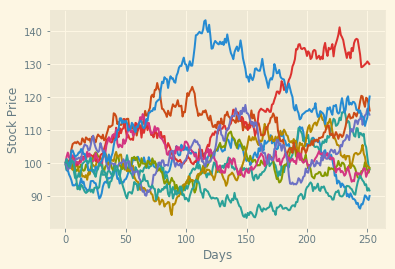

In [5]:
np.random.seed(2020)
# a sample of 10 daily stock paths for 1 year
stock_sample = [stock_gbm(0.1,0,0.2) for _ in range(10)]

with plt.style.context('Solarize_Light2'):
    for stock in stock_sample:
        plt.plot(range(253),stock)
    plt.xlabel('Days')
    plt.ylabel('Stock Price')

## Merton's Jump Diffusion

In [6]:
# Function for simulating daily stock price paths using Merton's Jump Diffusion
# with jumps in which,
# alpha is the annual return for stock
# delta is the dividend yield, also continuously compounded
# lambda_ is the mean of # of jump events annually
# sigma is the annual volitility
# alpha_j is the mean of jump magnitude RV Yis
# sigma_j is the standard deviation of jump magnitude RV Yis
# h is the period between two adjencent stock prices in years, default is 1day
# t is the entire duration of stock price path in years, default is 1 year
# s is the initial stock price, default is 100

def stock_merton(alpha, delta, lambda_, sigma, alpha_j, sigma_j, 
                     h=1/252, t=1, s=100):
    
    # expected jumps for each period h
    mean_poisson = lambda_*h
    s_list=[s]
    n=int(t/h)
    
    for i in range(n):
        # jumps for each period
        m = np.random.poisson(mean_poisson)
        # standard normal RV zi_s
        z=[]
        if m > 0:
            z += np.random.normal(0,1,m).tolist()
        # standard normal RV w  
        w = np.random.normal(0,1)
        # stock price 
        s *= np.exp((alpha - delta - lambda_*alpha_j - sigma**2/2-lambda_*sigma_j**2/2
                    )*h + sigma*np.sqrt(h)*w + m*alpha_j + sigma_j*sum(z))
        
        s_list.append(s)
    
    return s_list

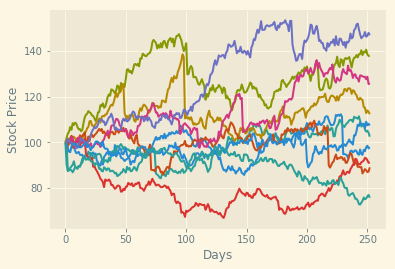

In [7]:
# a sample of 10 daily stock paths for 1 year
np.random.seed(2020)
stock_sample = [stock_merton(0.1,0,2,0.2,-0.05,0.05,t=1) for _ in range(10)]

with plt.style.context('Solarize_Light2'):
    for stock in stock_sample:
        plt.plot(range(253),stock)
    plt.xlabel('Days')
    plt.ylabel('Stock Price')




## Kou's Jump Diffusion

In [8]:
# inverse transform sampling for double exponential distribution
# n is the sample size
# p/q are upward/downward jump probability
# eta1/eta2 are exponential parameter

def double_exponential_sample(n=1,p=0.2,eta1=10,eta2=10):
    sample = []
    q=1-p
    for x in np.random.uniform(size = n):
        if x < q:
            sample.append(np.log(x/q)/eta2)
        else :
            sample.append(-np.log((1-x)/p)/eta1)
            
    return sample
    
    

In [9]:
double_exponential_sample(n=10)

[-0.04490880012339183,
 -0.014904928849063267,
 0.0408686420451392,
 -0.0033952043548289407,
 -0.011532448466046511,
 -0.05972916535051402,
 -0.08505448458631856,
 -0.15280644003794117,
 -0.017111327845048534,
 -0.0761309479441368]

In [10]:
# Function for simulating daily stock price paths using Kou's Jump Diffusion
# with jumps in which,
# alpha is the annual return for stock
# delta is the dividend yield, also continuously compounded
# lambda_ is the mean of # of jump events annually
# sigma is the annual volitily without jumps
# p is the probability for an upward jump
# eta1/eta2 is the jump magnitute parameter for upward/downward jumps
# h is the period between two adjencent stock prices in years, default is 1day
# t is the entire duration of stock price path in years, default is 1 year
# s is the initial stock price, default is 100
def stock_kou(alpha, delta, lambda_, sigma, p, eta1, eta2, 
                     h=1/252, t=1, s=100):
    
    # expected jumps for each period h
    mean_poisson = lambda_*h
    s_list=[s]
    n=int(t/h)
    q=1-p
    for i in range(n):
        # jumps for each period
        m = np.random.poisson(mean_poisson)
        # double exponential RV yi_s
        y=[]
        if m > 0:
            y = double_exponential_sample(m,p,eta1,eta2)
        # standard normal RV z  
        w = np.random.normal(0,1)
        # stock price 
        s *= np.exp((alpha - delta - 0.5*sigma**2-lambda_*(p*eta1/(
            eta1-1)+q*eta2/(eta2+1)-1))*h + sigma*np.sqrt(h)*w + sum(y))
        
        s_list.append(s)
    
    return s_list

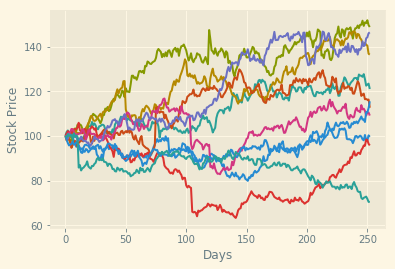

In [11]:
# a sample of 10 daily stock paths for 1 year
np.random.seed(2020)
stock_sample = [stock_kou(0.1,0,2,0.2,0.2,eta1=30,eta2=20) for _ in range(10)]

with plt.style.context('Solarize_Light2'):
    for stock in stock_sample:
        plt.plot(range(253),stock)
    plt.xlabel('Days')
    plt.ylabel('Stock Price')

## check SPY daily return's log normality

In [12]:
data = yf.download('SPY', end="2020-04-24",progressive=False)

[*********************100%***********************]  1 of 1 completed


In [13]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1993-01-29,43.96875,43.96875,43.75000,43.93750,26.299288,1003200
1993-02-01,43.96875,44.25000,43.96875,44.25000,26.486324,480500
1993-02-02,44.21875,44.37500,44.12500,44.34375,26.542448,201300
1993-02-03,44.40625,44.84375,44.37500,44.81250,26.822998,529400
1993-02-04,44.96875,45.09375,44.46875,45.00000,26.935240,531500


In [14]:
spy=np.array(data['Adj Close'])

In [15]:
returns = np.log(spy[1:]/spy[:(len(spy)-1)])

/Users/Kyriewang/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'SPY standardized daily return histogram and standard normal density')

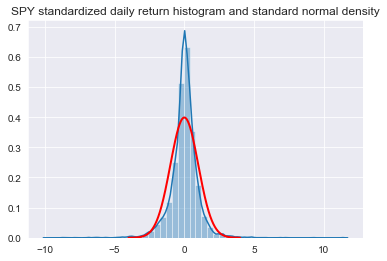

In [16]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
scaled_returns = scaler.fit_transform(returns.reshape(-1,1))
sns.set_style('darkgrid')

ax=sns.distplot(scaled_returns,bins=50)
xx = np.arange(-4, +4, 0.001)                                                   
yy = norm.pdf(xx)                                                         
ax.plot(xx, yy, 'r', lw=2)    
plt.title('SPY standardized daily return histogram and standard normal density')

In [17]:
# estimate annual return and volitility for SPY
vol = np.sqrt(np.var(returns)*252)
alpha = np.mean(returns)*252+vol**2/2
print([vol,alpha])

[0.18895527839176784, 0.10465576105283658]


/Users/Kyriewang/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'GBM standardized daily return histogram')

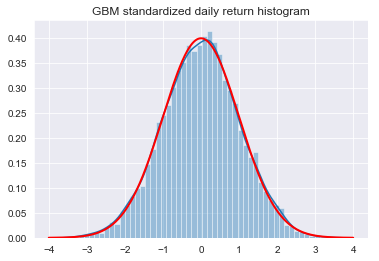

In [24]:
# how does the returns with GBM and estimated parameters look like
np.random.seed(2020)
sample_gbm = np.array(stock_gbm(alpha,0,vol,t=27))
returns_gbm = np.log(sample_gbm[1:]/sample_gbm[:(len(sample_gbm)-1)])
scaled_returns_gbm = scaler.fit_transform(returns_gbm.reshape(-1,1))
sns.set_style('darkgrid')

ax=sns.distplot(scaled_returns_gbm,bins=50)
xx = np.arange(-4, +4, 0.001)                                                   
yy = norm.pdf(xx)                                                         
ax.plot(xx, yy, 'r', lw=2)    
plt.title("GBM standardized daily return histogram")

In [19]:
# Jumps
returns_jump = returns[(abs(scaled_returns)>3)[:,0]]
print(np.sort(returns_jump))

[-0.11588651 -0.10363713 -0.10056885 -0.09274956 -0.08160271 -0.08131251
 -0.07713226 -0.07523328 -0.07401442 -0.07239761 -0.06734091 -0.0662242
 -0.05889324 -0.05700567 -0.05599317 -0.05423104 -0.05366331 -0.05227634
 -0.05204567 -0.05195974 -0.05119533 -0.04997677 -0.04875426 -0.04821651
 -0.04797402 -0.04689177 -0.04608883 -0.04604904 -0.04600565 -0.04595146
 -0.04582006 -0.04518356 -0.04499907 -0.04407566 -0.04405028 -0.0437443
 -0.04371543 -0.04301898 -0.04293598 -0.04281917 -0.04272257 -0.04170525
 -0.03989162 -0.03984114 -0.03951217 -0.03888139 -0.03849098 -0.03823033
 -0.03760809 -0.03708131 -0.03694861 -0.03656992 -0.03643527 -0.03614649
 -0.03582761 -0.0357692  -0.03541671 -0.03537937  0.03652723  0.03701559
  0.03718848  0.03720942  0.03767491  0.03776282  0.03791363  0.03861674
  0.03894544  0.03897328  0.03897558  0.03901502  0.0393148   0.04032558
  0.04055634  0.04068139  0.04070365  0.04081285  0.04117368  0.0414465
  0.04228591  0.04239497  0.04284927  0.04309887  0.04

In [20]:
#estimate merton's parameters
lambda_ = (sum(abs(scaled_returns)>3)/len(returns)*252)[0]
#estimate sigma_j using assumed log return's normality
sigma_j = (np.sort(returns_jump)[len(returns_jump)-1] - np.sort(returns_jump)[0])/6
alpha_j = np.mean(returns_jump)
sigma = np.sqrt(np.var(returns)*252-lambda_*(sigma_j**2+alpha_j**2))
alpha = np.mean(returns[(abs(scaled_returns)<=3)[:,0]])*252+sigma**2/2
kwargs = {'alpha':alpha,'delta':0,'lambda_':lambda_, 'sigma':sigma, 'alpha_j': alpha_j, 
          'sigma_j':sigma_j,'t':len(returns)/252}
kwargs

{'alpha': 0.11719195987387743,
 'delta': 0,
 'lambda_': 4.042584220504594,
 'sigma': 0.16897205534696766,
 'alpha_j': -0.003577288046560992,
 'sigma_j': 0.04191064766273266,
 't': 27.21031746031746}

/Users/Kyriewang/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,"Merton's Jump Diffusion standardized daily return histogram")

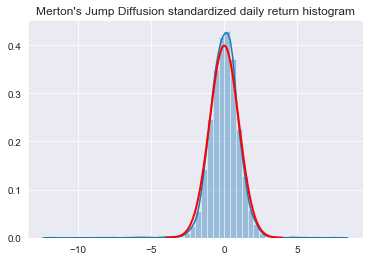

In [21]:
#check merton's return distribution
np.random.seed(2020)
sample_merton = np.array(stock_merton(**kwargs))

returns_merton = np.log(sample_merton[1:]/sample_merton[:(len(sample_merton)-1)])

scaled_returns_merton = scaler.fit_transform(returns_merton.reshape(-1,1))
sns.set_style('darkgrid')

ax=sns.distplot(scaled_returns_merton)
xx = np.arange(-4, +4, 0.001)                                                   
yy = norm.pdf(xx)                                                         
ax.plot(xx, yy, 'r', lw=2)    
plt.title("Merton's Jump Diffusion standardized daily return histogram")

In [22]:
kwargs = {'delta':0,'lambda_':lambda_,'t':len(returns)/252}

p = sum(returns_jump>0)/len(returns_jump)
q = 1-p
# solve nonlinear system to get eta1, eta2 estimation
def equations(u):
    x,y = u
    return (p/x-q/y-np.mean(returns_jump),(1-q**2)/x**2+(1-p**2)/y**2 + 2*
            p*q/(x*y)-np.var(returns_jump))
eta1, eta2 = fsolve(equations, (5,10))

# sigma correction
# sigma = np.std(returns)*np.sqrt(252)
sigma = np.sqrt(np.var(returns[(abs(scaled_returns)<3)[:,0]])*252-2*lambda_*(p/eta1**2+(1-p)/eta2**2))
alpha = np.mean(returns[(abs(scaled_returns)<=3)[:,0]])*252+sigma**2/2 + lambda_*(
    p*eta1/(eta1-1)+q*eta2/(eta2+1)-1)
kwargs.update({'alpha':alpha,'sigma':sigma,'p':p,'eta1':eta1,'eta2':eta2})
kwargs

{'delta': 0,
 'lambda_': 4.042584220504594,
 't': 27.21031746031746,
 'alpha': 0.1003629423718771,
 'sigma': 0.10806809601382703,
 'p': 0.4727272727272727,
 'eta1': 26.830703181284946,
 'eta2': 24.875836864496033}

/Users/Kyriewang/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,"Kou's Jump Diffusion standardized daily return histogram")

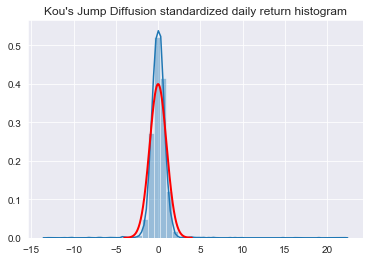

In [23]:
#check Kou's return distribution
np.random.seed(2020)
sample_kou = np.array(stock_kou(**kwargs))
returns_kou = np.log(sample_kou[1:]/sample_kou[:(len(sample_kou)-1)])

scaled_returns_kou = scaler.fit_transform(returns_kou.reshape(-1,1))
sns.set_style('darkgrid')

ax=sns.distplot(scaled_returns_kou,bins=50)
xx = np.arange(-4, +4, 0.001)                                                   
yy = norm.pdf(xx)                                                         
ax.plot(xx, yy, 'r', lw=2)    
plt.title("Kou's Jump Diffusion standardized daily return histogram")

# Monte Carlo Least Square for American Options

In [20]:
# American option valuation function using naive Monte Carlo, in which 
# s is the current stock price,
# k is the strike price, floater
# r is the countinuosly compounded annual risk free rate, floater
# npath is the # of paths generated in Monte Carlo simulation, integer
# call is the option type, Flase or 0 when the option is a put, boolean 
# kwargs are the arguments from function stock_price_path(**kwargs)

# note that we have arguments in the kwargs that are prevalent in both funtions
# t is the time of option contract till expiration in years here
# h is the time inteval inbetween intermittent observations(of stock& options)
# s is the current stock price here

def option_value_american(k, r, npath=500, call=True, **kwargs):
    # pass prevalent parameters from kwargs
    s = kwargs.get('s',100.0)
    t = kwargs.get('t',1.0)
    h = kwargs.get('h',1/252)
    # length of paths
    n = int(np.floor(t/h))
    
    # store paths of stock prices, stock_price_path() include
    # initial price, so the paths generated should have lenth n+1
    paths = np.zeros((npath,n+1))
    for i in range(npath):
        paths[i] = stock_gbm(**kwargs)   
        
    # initialize 2d array storing cashflows
    cash_flow = np.zeros((npath,n))
    
    # calculate call option value
    if call == 1:
        # payoff at end node
        cash_flow[:,-1] = ((paths[:,-1]-k)>0)*(paths[:,-1]-k)
        
        for i in range(n-1):
    
            # continuation value initializtion
            discount = list(map(lambda x: np.exp(-r*h*x), range(1,i+2)))
            price = paths[:,-2-i]
            cv = (cash_flow[:,(n-i-1):n]*discount).sum(axis=1)*(price > k)
                
            # esitmate cv with polynomial regression of degree 3, if price>k 
            # holds for less than 4 nodes, run regression with lower degrees
            # we don't need cv for out-of-money nodes due to no early exercise
            
            cv_reg = cv[price > k] #regression independent variable
            x = price[price > k]
            if len(cv_reg) > 4:
                A = np.array([np.ones(len(x)),x,x**2,x**3]).transpose() #design matrix
                clf = linear_model.LinearRegression(fit_intercept=False)
                clf.fit(A, cv_reg)                              
                betahat = clf.coef_
                #betahat = np.linalg.lstsq(A,cv_reg,rcond=None)[0] #coefficients
                cv = (betahat*np.array([np.ones(npath),price,price**2,price**3
                                       ]).transpose()).sum(axis=1)*(price > k)
                
            elif len(cv_reg) == 4:
                A = np.array([np.ones(len(x)),x,x**2]).transpose() #design matrix
                clf = linear_model.LinearRegression(fit_intercept=False)
                clf.fit(A, cv_reg)                              
                betahat = clf.coef_
                #betahat = np.linalg.lstsq(A,cv_reg,rcond=None)[0] #coefficients
                cv = (betahat*np.array([np.ones(npath),price,price**2
                                       ]).transpose()).sum(axis=1)*(price > k)
            elif len(cv_reg) == 3:
                A = np.array([np.ones(len(x)),x]).transpose() #design matrix
                clf = linear_model.LinearRegression(fit_intercept=False)
                clf.fit(A, cv_reg)                              
                betahat = clf.coef_
                #betahat = np.linalg.lstsq(A,cv_reg,rcond=None)[0] #coefficients
                cv = (betahat*np.array([np.ones(npath),price
                                       ]).transpose()).sum(axis=1)*(price > k)
            elif len(cv_reg) > 0:
                cv = np.mean(cv_reg)*(price > k)
                
            # assign cashflow of payoff/0 depending on whether early exercise
            # if early exercise, subsequent cashflow in the path is assigned 0
            cash_flow[:,-2-i] = (price-k)*(price - k - cv > 0)
            early_node = np.array(range(npath))*(cash_flow[:,-2-i] > 0)
            early_index = early_node[early_node > 0]
            
            for j in early_index:
                cash_flow[j,(n-i-1):n] = 0
        
        # discount cash flow to present to get the option value
        discount = list(map(lambda x: np.exp(-r*h*x), range(1,n+1)))
        value = (cash_flow*discount).sum()/npath
        
        
    # calculate put option value
    else:
        # payoff at end node
        cash_flow[:,-1] = ((k-paths[:,-1])>0)*(k-paths[:,-1])
        
        for i in range(n-1):
    
            # continuation value initializtion
            discount = list(map(lambda x: np.exp(-r*h*x), range(1,i+2)))
            price = paths[:,-2-i]
            cv = (cash_flow[:,(n-i-1):n]*discount).sum(axis=1)*(price < k)
                
            # esitmate cv with polynomial regression of degree 3, if price<k 
            # holds for less than 4 nodes, run regression with lower degrees
            # we don't need cv for out-of-money nodes due to no early exercise
            
            cv_reg = cv[price < k] #regression independent variable
            x = price[price < k]
            if len(cv_reg) > 4:
                A = np.array([np.ones(len(x)),x,x**2,x**3]).transpose() 
                clf = linear_model.LinearRegression(fit_intercept=False)
                clf.fit(A, cv_reg)                              
                betahat = clf.coef_
                #betahat = np.linalg.lstsq(A,cv_reg,rcond=None)[0] #coefficients
                cv = (betahat*np.array([np.ones(npath),price,price**2,price**3
                                       ]).transpose()).sum(axis=1)*(price < k) 
               
            elif len(cv_reg) == 4:
                A = np.array([np.ones(len(x)),x,x**2]).transpose() 
                clf = linear_model.LinearRegression(fit_intercept=False)
                clf.fit(A, cv_reg)                              
                betahat = clf.coef_
                #betahat = np.linalg.lstsq(A,cv_reg,rcond=None)[0] #coefficients
                cv = (betahat*np.array([np.ones(npath),price,price**2
                                       ]).transpose()).sum(axis=1)*(price < k)
            elif len(cv_reg) == 3:
                A = np.array([np.ones(len(x)),x]).transpose() 
                clf = linear_model.LinearRegression(fit_intercept=False)
                clf.fit(A, cv_reg)                              
                betahat = clf.coef_
                #betahat = np.linalg.lstsq(A,cv_reg,rcond=None)[0] #coefficients
                cv = (betahat*np.array([np.ones(npath),price
                                       ]).transpose()).sum(axis=1)*(price < k)
            elif len(cv_reg) > 0:
                cv = np.mean(cv_reg)*(price < k)

                
            # assign cashflow of payoff/0 depending on whether early exercise
            # if early exercise, subsequent cashflow in the path is 0
            cash_flow[:,-2-i] = (k - price)*(k - price - cv > 0)
            early_node = np.array(range(npath))*(cash_flow[:,-2-i] > 0)
            early_index = early_node[early_node > 0]
            
            for j in early_index:
                cash_flow[j,(n-i-1):n] = 0
        
        # discount cash flow to present to get the option value
        discount = list(map(lambda x: np.exp(-r*h*x), range(1,n+1)))
        value = (cash_flow*discount).sum()/npath       
        
    
    return value

In [21]:
kwargs = {'alpha':0.03, 'delta':0, 'sigma':0.2, 't':1/12, 's':100}

np.random.seed(2020)
option_value_american(105,0.03,call=False,**kwargs)

5.3499123199534

## efficient Monte Carlo pricing function for american options implemented with control variate method and GBM stock price model

In [22]:
# efficient Monte Carlo pricing function for american options implemented 
# with control variate method, with european option as the control variate
# since its value is somewhat correlated with( no goreater than) its 
# american counterpart, while its pricing formula is known 

# a funtion which estimates American and European options using the same sample
def option_value(k, r, npath=500, call=True, **kwargs):
    # pass prevalent parameters from kwargs
    s = kwargs.get('s',100.0)
    t = kwargs.get('t',1.0)
    h = kwargs.get('h',1/252)
    # length of paths
    n = int(np.floor(t/h))
    
    # store paths of stock prices, stock_price_path() include
    # initial price, so the paths generated should have lenth n+1
    paths = np.zeros((npath,n+1))
    for i in range(npath):
        paths[i] = stock_gbm(**kwargs)   
        
    # initialize 2d array storing cashflows
    cash_flow = np.zeros((npath,n))
    
    # calculate call option value
    if call == 1:
        # payoff at end node
        cash_flow[:,-1] = ((paths[:,-1]-k)>0)*(paths[:,-1]-k)
        ## simulation estimated value of European call option
        value_euro = np.mean(cash_flow[:,-1]*np.exp(-r*t))
        
        for i in range(n-1):
    
            # continuation value initializtion
            discount = list(map(lambda x: np.exp(-r*h*x), range(1,i+2)))
            price = paths[:,-2-i]
            cv = (cash_flow[:,(n-i-1):n]*discount).sum(axis=1)*(price > k)
                
            # esitmate cv with polynomial regression of degree 3, if price>k 
            # holds for less than 4 nodes, run regression with lower degrees
            # we don't need cv for out-of-money nodes due to no early exercise
            
            cv_reg = cv[price > k] #regression independent variable
            x = price[price > k]
            if len(cv_reg) > 4:
                A = np.array([np.ones(len(x)),x,x**2,x**3]).transpose() #design matrix
                clf = linear_model.LinearRegression(fit_intercept=False)
                clf.fit(A, cv_reg)                              
                betahat = clf.coef_
                #betahat = np.linalg.lstsq(A,cv_reg,rcond=None)[0] #coefficients
                cv = (betahat*np.array([np.ones(npath),price,price**2,price**3
                                       ]).transpose()).sum(axis=1)*(price > k)    
            elif len(cv_reg) == 4:
                A = np.array([np.ones(len(x)),x,x**2]).transpose() #design matrix
                clf = linear_model.LinearRegression(fit_intercept=False)
                clf.fit(A, cv_reg)                              
                betahat = clf.coef_
                #betahat = np.linalg.lstsq(A,cv_reg,rcond=None)[0] #coefficients
                cv = (betahat*np.array([np.ones(npath),price,price**2
                                       ]).transpose()).sum(axis=1)*(price > k)
            elif len(cv_reg) == 3:
                A = np.array([np.ones(len(x)),x]).transpose() #design matrix
                clf = linear_model.LinearRegression(fit_intercept=False)
                clf.fit(A, cv_reg)                              
                betahat = clf.coef_
                #betahat = np.linalg.lstsq(A,cv_reg,rcond=None)[0] #coefficients
                cv = (betahat*np.array([np.ones(npath),price
                                       ]).transpose()).sum(axis=1)*(price > k)
            elif len(cv_reg) > 0:
                cv = np.mean(cv_reg)*(price > k)
                
            # assign cashflow of payoff/0 depending on whether early exercise
            # if early exercise, subsequent cashflow in the path is assigned 0
            cash_flow[:,-2-i] = (price-k)*(price - k - cv > 0)
            early_node = np.array(range(npath))*(cash_flow[:,-2-i] > 0)
            early_index = early_node[early_node > 0]
            
            for j in early_index:
                cash_flow[j,(n-i-1):n] = 0
        
        # discount cash flow to present to get the option value
        discount = list(map(lambda x: np.exp(-r*h*x), range(1,n+1)))
        value = (cash_flow*discount).sum()/npath
        
        
    # calculate put option value
    else:
        # payoff at end node
        cash_flow[:,-1] = ((k-paths[:,-1])>0)*(k-paths[:,-1])
        ## simulation estimated value of European put option
        value_euro = np.mean(cash_flow[:,-1]*np.exp(-r*t))
        for i in range(n-1):
    
            # continuation value initializtion
            discount = list(map(lambda x: np.exp(-r*h*x), range(1,i+2)))
            price = paths[:,-2-i]
            cv = (cash_flow[:,(n-i-1):n]*discount).sum(axis=1)*(price < k)
                
            # esitmate cv with polynomial regression of degree 3, if price<k 
            # holds for less than 4 nodes, run regression with lower degrees
            # we don't need cv for out-of-money nodes due to no early exercise
            
            cv_reg = cv[price < k] #regression independent variable
            x = price[price < k]
            if len(cv_reg) > 4:
                A = np.array([np.ones(len(x)),x,x**2,x**3]).transpose() #design matrix
                clf = linear_model.LinearRegression(fit_intercept=False)
                clf.fit(A, cv_reg)                              
                betahat = clf.coef_
                #betahat = np.linalg.lstsq(A,cv_reg,rcond=None)[0] #coefficients
                cv = (betahat*np.array([np.ones(npath),price,price**2,price**3
                                       ]).transpose()).sum(axis=1)*(price < k)    
            elif len(cv_reg) == 4:
                A = np.array([np.ones(len(x)),x,x**2]).transpose() #design matrix
                clf = linear_model.LinearRegression(fit_intercept=False)
                clf.fit(A, cv_reg)                              
                betahat = clf.coef_
                #betahat = np.linalg.lstsq(A,cv_reg,rcond=None)[0] #coefficients
                cv = (betahat*np.array([np.ones(npath),price,price**2
                                       ]).transpose()).sum(axis=1)*(price < k)
            elif len(cv_reg) == 3:
                A = np.array([np.ones(len(x)),x]).transpose() #design matrix
                clf = linear_model.LinearRegression(fit_intercept=False)
                clf.fit(A, cv_reg)                              
                betahat = clf.coef_
                #betahat = np.linalg.lstsq(A,cv_reg,rcond=None)[0] #coefficients
                cv = (betahat*np.array([np.ones(npath),price
                                       ]).transpose()).sum(axis=1)*(price < k)
            elif len(cv_reg) > 0:
                cv = np.mean(cv_reg)*(price < k)

                
            # assign cashflow of payoff/0 depending on whether early exercise
            # if early exercise, subsequent cashflow in the path is 0
            cash_flow[:,-2-i] = (k - price)*(k - price - cv > 0)
            early_node = np.array(range(npath))*(cash_flow[:,-2-i] > 0)
            early_index = early_node[early_node > 0]
            
            for j in early_index:
                cash_flow[j,(n-i-1):n] = 0
        
        # discount cash flow to present to get the option value
        discount = list(map(lambda x: np.exp(-r*h*x), range(1,n+1)))
        value = (cash_flow*discount).sum()/npath       
        
    
    return [value,value_euro]


def cv_option_value_american(k, r, thetahat, npath=500, call=True, **kwargs):
    # for robustness, force npath>=500
    npath = 500 if npath < 500 else npath
    # pass prevalent parameters from kwargs
    s = kwargs.get('s',100.0)
    t = kwargs.get('t',1.0)
    delta = kwargs.get('delta')
    sigma = kwargs.get('sigma')
    h = kwargs.get('h',1/252)
    # length of paths
    n = int(np.floor(t/h))
    
    # B-S value for European options
    vol = sigma
    d1 = (np.log(s/k) + (r - delta + vol**2/2)*t ) / (vol*np.sqrt(t))
    d2 = d1 - vol * np.sqrt(t)
    value_bs = (s*np.exp(-delta*t) * norm.cdf(d1) - k*np.exp(-r*t) * norm.cdf(d2))*call+(
        k*np.exp(-r*t)*norm.cdf(-d2) - s*np.exp(-delta*t)*norm.cdf(-d1))*(1-call)
    # control variate correction
    [value_am,value_euro] = option_value(k,r,npath,call,**kwargs)
    value_cv = value_am + thetahat*(value_bs-value_euro)

    return value_cv



    
    




In [23]:
np.random.seed(2020)
kwargs = {'alpha':0.03, 'delta':0, 'sigma':0.2, 't':1/12, 's':100}
# estimate optimal theta for control variate correction
sample =np.array([option_value(105,0.03,call=False,**kwargs) for i in range(50)])
y = sample[:,0]
x = sample[:,1]
cov = np.cov(x,y)
theta_hat = cov[0][1]/cov[0][0]

cv_option_value_american(105,0.03,theta_hat,npath=500,call=False,**kwargs)

5.840704381275777

## efficient Monte Carlo pricing function for american options implemented with antithetic variate method and GBM stock price model

In [24]:
# efficient Monte Carlo pricing function for american options implemented 
# with antithetic variate method and GBM stock price model

def antithetic_option_value_american(k, r, npath=500, call=True, **kwargs):
    # for robustness, force npath>=500
    npath = 500 if npath < 500 else npath
    # pass prevalent parameters from kwargs
    s = kwargs.get('s',100.0)
    t = kwargs.get('t',1.0)
    delta = kwargs.get('delta')
    sigma = kwargs.get('sigma')
    h = kwargs.get('h',1/252)

    # length of paths
    n = int(np.floor(t/h))
    paths = np.zeros((npath//2*2,n+1))
    for i in range(npath//2):
        sample = antithetic_stock_gbm(**kwargs)
        paths[2*i] = sample[0]
        paths[2*i+1] = sample[1]
        
    
    # initialize 2d array storing cashflows
    cash_flow = np.zeros((npath,n))
    
       # calculate call option value
    if call == 1:
        # payoff at end node
        cash_flow[:,-1] = ((paths[:,-1]-k)>0)*(paths[:,-1]-k)
        
        for i in range(n-1):
    
            # continuation value initializtion
            discount = list(map(lambda x: np.exp(-r*h*x), range(1,i+2)))
            price = paths[:,-2-i]
            cv = (cash_flow[:,(n-i-1):n]*discount).sum(axis=1)*(price > k)
                
            # esitmate cv with polynomial regression of degree 3, if price>k 
            # holds for less than 4 nodes, run regression with lower degrees
            # we don't need cv for out-of-money nodes due to no early exercise
            
            cv_reg = cv[price > k] #regression independent variable
            x = price[price > k]
            if len(cv_reg) > 4:
                A = np.array([np.ones(len(x)),x,x**2,x**3]).transpose() #design matrix
                clf = linear_model.LinearRegression(fit_intercept=False)
                clf.fit(A, cv_reg)                              
                betahat = clf.coef_
                #betahat = np.linalg.lstsq(A,cv_reg,rcond=None)[0] #coefficients
                cv = (betahat*np.array([np.ones(npath),price,price**2,price**3
                                       ]).transpose()).sum(axis=1)*(price > k)    
            elif len(cv_reg) == 4:
                A = np.array([np.ones(len(x)),x,x**2]).transpose() #design matrix
                clf = linear_model.LinearRegression(fit_intercept=False)
                clf.fit(A, cv_reg)                              
                betahat = clf.coef_
                #betahat = np.linalg.lstsq(A,cv_reg,rcond=None)[0] #coefficients
                cv = (betahat*np.array([np.ones(npath),price,price**2
                                       ]).transpose()).sum(axis=1)*(price > k)
            elif len(cv_reg) == 3:
                A = np.array([np.ones(len(x)),x]).transpose() #design matrix
                clf = linear_model.LinearRegression(fit_intercept=False)
                clf.fit(A, cv_reg)                              
                betahat = clf.coef_
                #betahat = np.linalg.lstsq(A,cv_reg,rcond=None)[0] #coefficients
                cv = (betahat*np.array([np.ones(npath),price
                                       ]).transpose()).sum(axis=1)*(price > k)
            elif len(cv_reg) > 0:
                cv = np.mean(cv_reg)*(price > k)
                
            # assign cashflow of payoff/0 depending on whether early exercise
            # if early exercise, subsequent cashflow in the path is assigned 0
            cash_flow[:,-2-i] = (price-k)*(price - k - cv > 0)
            early_node = np.array(range(npath))*(cash_flow[:,-2-i] > 0)
            early_index = early_node[early_node > 0]
            
            for j in early_index:
                cash_flow[j,(n-i-1):n] = 0
        
        # discount cash flow to present to get the option value
        discount = list(map(lambda x: np.exp(-r*h*x), range(1,n+1)))
        value = (cash_flow*discount).sum()/npath
        
        
    # calculate put option value
    else:
        # payoff at end node
        cash_flow[:,-1] = ((k-paths[:,-1])>0)*(k-paths[:,-1])
        
        for i in range(n-1):
    
            # continuation value initializtion
            discount = list(map(lambda x: np.exp(-r*h*x), range(1,i+2)))
            price = paths[:,-2-i]
            cv = (cash_flow[:,(n-i-1):n]*discount).sum(axis=1)*(price < k)
                
            # esitmate cv with polynomial regression of degree 3, if price<k 
            # holds for less than 4 nodes, run regression with lower degrees
            # we don't need cv for out-of-money nodes due to no early exercise
            
            cv_reg = cv[price < k] #regression independent variable
            x = price[price < k]
            if len(cv_reg) > 4:
                A = np.array([np.ones(len(x)),x,x**2,x**3]).transpose() #design matrix
                clf = linear_model.LinearRegression(fit_intercept=False)
                clf.fit(A, cv_reg)                              
                betahat = clf.coef_
                #betahat = np.linalg.lstsq(A,cv_reg,rcond=None)[0] #coefficients
                cv = (betahat*np.array([np.ones(npath),price,price**2,price**3
                                       ]).transpose()).sum(axis=1)*(price < k)    
            elif len(cv_reg) == 4:
                A = np.array([np.ones(len(x)),x,x**2]).transpose() #design matrix
                clf = linear_model.LinearRegression(fit_intercept=False)
                clf.fit(A, cv_reg)                              
                betahat = clf.coef_
                #betahat = np.linalg.lstsq(A,cv_reg,rcond=None)[0] #coefficients
                cv = (betahat*np.array([np.ones(npath),price,price**2
                                       ]).transpose()).sum(axis=1)*(price < k)
            elif len(cv_reg) == 3:
                A = np.array([np.ones(len(x)),x]).transpose() #design matrix
                clf = linear_model.LinearRegression(fit_intercept=False)
                clf.fit(A, cv_reg)                              
                betahat = clf.coef_
                #betahat = np.linalg.lstsq(A,cv_reg,rcond=None)[0] #coefficients
                cv = (betahat*np.array([np.ones(npath),price
                                       ]).transpose()).sum(axis=1)*(price < k)
            elif len(cv_reg) > 0:
                cv = np.mean(cv_reg)*(price < k)

                
            # assign cashflow of payoff/0 depending on whether early exercise
            # if early exercise, subsequent cashflow in the path is 0
            cash_flow[:,-2-i] = (k - price)*(k - price - cv > 0)
            early_node = np.array(range(npath))*(cash_flow[:,-2-i] > 0)
            early_index = early_node[early_node > 0]
            
            for j in early_index:
                cash_flow[j,(n-i-1):n] = 0
        
        # discount cash flow to present to get the option value
        discount = list(map(lambda x: np.exp(-r*h*x), range(1,n+1)))
        value = (cash_flow*discount).sum()/npath       
        
    
    return value


# refine stock path simulation using antithetic variate

def antithetic_stock_gbm(alpha, delta, sigma, h=1/252, t=1, s=100):
    s_list=[s]
    n=int(t/h)
    s_anti = s
    s_anti_list = [s]
    for i in range(n):
        z = np.random.normal(0,1)
        # stock price 
        s *= np.exp((alpha - delta - 0.5*sigma**2)*h + sigma*np.sqrt(h)*z)        
        s_anti *=  np.exp((alpha - delta - 0.5*sigma**2)*h + sigma*np.sqrt(h)*(-z))   
        s_list.append(s)
        s_anti_list.append(s_anti)
        
    return [s_list,s_anti_list]


In [25]:
np.random.seed(2020)
kwargs = {'alpha':0.03, 'delta':0, 'sigma':0.2, 't':1/12, 's':100}

antithetic_option_value_american(105,0.03,call=False,**kwargs)

5.762619103255669

## Efficient Monte Carlo pricing function for american options implemented with Stratified Sampling and GBM stock price model

In [26]:
# American option valuation function using naive Monte Carlo, in which 
# s is the current stock price,
# k is the strike price, floater
# r is the countinuosly compounded annual risk free rate, floater
# npath is the # of paths generated in Monte Carlo simulation, integer
# call is the option type, Flase or 0 when the option is a put, boolean 
# kwargs are the arguments from function stock_price_path(**kwargs)

# note that we have arguments in the kwargs that are prevalent in both funtions
# t is the time of option contract till expiration in years here
# h is the time inteval inbetween intermittent observations(of stock& options)
# s is the current stock price here

def stratified_option_value_american(k, r, npath=500, call=True, **kwargs):
    # pass prevalent parameters from kwargs
    s = kwargs.get('s',100.0)
    t = kwargs.get('t',1.0)
    h = kwargs.get('h',1/252)
    # length of paths
    n = int(np.floor(t/h))
    
    # store paths of stock prices, stock_price_path() include
    # initial price, so the paths generated should have lenth n+1
    paths = stock_gbm_stratified(npath,**kwargs)
        
    # initialize 2d array storing cashflows
    cash_flow = np.zeros((npath,n))
    
    
    
    
    # calculate call option value
    if call == 1:
        # payoff at end node
        cash_flow[:,-1] = ((paths[:,-1]-k)>0)*(paths[:,-1]-k)
        
        for i in range(n-1):
    
            # continuation value initializtion
            discount = list(map(lambda x: np.exp(-r*h*x), range(1,i+2)))
            price = paths[:,-2-i]
            cv = (cash_flow[:,(n-i-1):n]*discount).sum(axis=1)*(price > k)
                
            # esitmate cv with polynomial regression of degree 3, if price>k 
            # holds for less than 4 nodes, run regression with lower degrees
            # we don't need cv for out-of-money nodes due to no early exercise
            
            cv_reg = cv[price > k] #regression independent variable
            x = price[price > k]
            if len(cv_reg) > 4:
                A = np.array([np.ones(len(x)),x,x**2,x**3]).transpose() #design matrix
                clf = linear_model.LinearRegression(fit_intercept=False)
                clf.fit(A, cv_reg)                              
                betahat = clf.coef_
                #betahat = np.linalg.lstsq(A,cv_reg,rcond=None)[0] #coefficients
                cv = (betahat*np.array([np.ones(npath),price,price**2,price**3
                                       ]).transpose()).sum(axis=1)*(price > k)
                
            elif len(cv_reg) == 4:
                A = np.array([np.ones(len(x)),x,x**2]).transpose() #design matrix
                clf = linear_model.LinearRegression(fit_intercept=False)
                clf.fit(A, cv_reg)                              
                betahat = clf.coef_
                #betahat = np.linalg.lstsq(A,cv_reg,rcond=None)[0] #coefficients
                cv = (betahat*np.array([np.ones(npath),price,price**2
                                       ]).transpose()).sum(axis=1)*(price > k)
            elif len(cv_reg) == 3:
                A = np.array([np.ones(len(x)),x]).transpose() #design matrix
                clf = linear_model.LinearRegression(fit_intercept=False)
                clf.fit(A, cv_reg)                              
                betahat = clf.coef_
                #betahat = np.linalg.lstsq(A,cv_reg,rcond=None)[0] #coefficients
                cv = (betahat*np.array([np.ones(npath),price
                                       ]).transpose()).sum(axis=1)*(price > k)
            elif len(cv_reg) > 0:
                cv = np.mean(cv_reg)*(price > k)
                
            # assign cashflow of payoff/0 depending on whether early exercise
            # if early exercise, subsequent cashflow in the path is assigned 0
            cash_flow[:,-2-i] = (price-k)*(price - k - cv > 0)
            early_node = np.array(range(npath))*(cash_flow[:,-2-i] > 0)
            early_index = early_node[early_node > 0]
            
            for j in early_index:
                cash_flow[j,(n-i-1):n] = 0
        
        # discount cash flow to present to get the option value
        discount = list(map(lambda x: np.exp(-r*h*x), range(1,n+1)))
        value = (cash_flow*discount).sum()/npath
        
        
    # calculate put option value
    else:
        # payoff at end node
        cash_flow[:,-1] = ((k-paths[:,-1])>0)*(k-paths[:,-1])
        
        for i in range(n-1):
    
            # continuation value initializtion
            discount = list(map(lambda x: np.exp(-r*h*x), range(1,i+2)))
            price = paths[:,-2-i]
            cv = (cash_flow[:,(n-i-1):n]*discount).sum(axis=1)*(price < k)
                
            # esitmate cv with polynomial regression of degree 3, if price<k 
            # holds for less than 4 nodes, run regression with lower degrees
            # we don't need cv for out-of-money nodes due to no early exercise
            
            cv_reg = cv[price < k] #regression independent variable
            x = price[price < k]
            if len(cv_reg) > 4:
                A = np.array([np.ones(len(x)),x,x**2,x**3]).transpose() 
                clf = linear_model.LinearRegression(fit_intercept=False)
                clf.fit(A, cv_reg)                              
                betahat = clf.coef_
                #betahat = np.linalg.lstsq(A,cv_reg,rcond=None)[0] #coefficients
                cv = (betahat*np.array([np.ones(npath),price,price**2,price**3
                                       ]).transpose()).sum(axis=1)*(price < k) 
               
            elif len(cv_reg) == 4:
                A = np.array([np.ones(len(x)),x,x**2]).transpose() 
                clf = linear_model.LinearRegression(fit_intercept=False)
                clf.fit(A, cv_reg)                              
                betahat = clf.coef_
                #betahat = np.linalg.lstsq(A,cv_reg,rcond=None)[0] #coefficients
                cv = (betahat*np.array([np.ones(npath),price,price**2
                                       ]).transpose()).sum(axis=1)*(price < k)
            elif len(cv_reg) == 3:
                A = np.array([np.ones(len(x)),x]).transpose() 
                clf = linear_model.LinearRegression(fit_intercept=False)
                clf.fit(A, cv_reg)                              
                betahat = clf.coef_
                #betahat = np.linalg.lstsq(A,cv_reg,rcond=None)[0] #coefficients
                cv = (betahat*np.array([np.ones(npath),price
                                       ]).transpose()).sum(axis=1)*(price < k)
            elif len(cv_reg) > 0:
                cv = np.mean(cv_reg)*(price < k)

                
            # assign cashflow of payoff/0 depending on whether early exercise
            # if early exercise, subsequent cashflow in the path is 0
            cash_flow[:,-2-i] = (k - price)*(k - price - cv > 0)
            early_node = np.array(range(npath))*(cash_flow[:,-2-i] > 0)
            early_index = early_node[early_node > 0]
            
            for j in early_index:
                cash_flow[j,(n-i-1):n] = 0
        
        # discount cash flow to present to get the option value
        discount = list(map(lambda x: np.exp(-r*h*x), range(1,n+1)))
        value = (cash_flow*discount).sum()/npath       
        
    
    return value


## stock paths with GBM model and generated by Stratified Sampling
def stock_gbm_stratified(npath, alpha, delta, sigma, h=1/252, t=1, s=100):
    
    n=int(t/h)
    paths = np.zeros((npath,n+1))
    #stratified sampling
    z=norm.ppf(lhs(1,samples=n*npath))
    for i in range(npath):
        paths[i][:] = np.cumprod([s]+(np.exp((alpha - delta - 0.5*sigma**2)*h + 
                               sigma*np.sqrt(h)*z[(n*i):(n*i+n)]).flatten().tolist()))
   
    return paths

In [27]:
np.random.seed(2020)
kwargs = {'alpha':0.03, 'delta':0, 'sigma':0.2, 't':1/12, 's':100}

stratified_option_value_american(105,0.03,call=False,**kwargs)

5.556335409099113

# Compare variance of Monte Carlo estimates

In [28]:
np.random.seed(2020)
kwargs = {'alpha':0.03, 'delta':0, 'sigma':0.3, 't':1/12, 's':100}

# estimate optimal theta for control variate correction
sample =np.array([option_value(110,0.03,call=False,**kwargs) for i in range(500)])
y = sample[:,0]
x = sample[:,1]

In [29]:
A = np.array([np.ones(len(x)),x]).transpose()

A.shape

(500, 2)

In [30]:
# check correlation between MC estimated Ameircan and European option value
theta_hat = np.linalg.lstsq(A,y,rcond=None)[0][1]
np.cov(x,y)[0,1]/np.sqrt(np.cov(x,y)[0,0]*np.cov(x,y)[1,1])


0.829290145784211

In [31]:
np.random.seed(2020)
sim_naive = [option_value_american(110,0.03,call=False,npath=1000,**kwargs) for i in range(200)]
sim_cv = [cv_option_value_american(110,0.03,theta_hat,call=False,npath=1000,**kwargs) for i in range(200)]
sim_anti = [antithetic_option_value_american(110,0.03,call=False,npath=1000,**kwargs) for i in range(200)]
sim_stratified = [stratified_option_value_american(110,0.03,call=False,npath=1000,**kwargs) for i in range(200)]

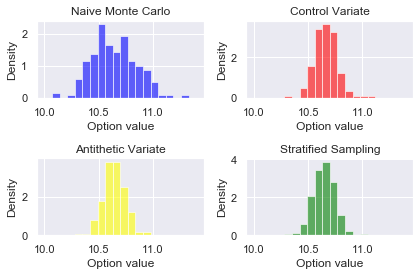

In [100]:
fig, ax = plt.subplots(2,2)
bins = 20
#fig.suptitle("Monte Carlo American Option Estimation with different variance reduction methods")
ax[0,0].set_title('Naive Monte Carlo')
ax[0,0].hist(sim_naive,bins,density=1,range=[10,11.4],facecolor='blue',alpha=0.6)
ax[0,1].set_title('Control Variate')
ax[0,1].hist(sim_cv,bins,density=1,range=[10,11.4],facecolor='red',alpha=0.6)
ax[1,0].set_title('Antithetic Variate')
ax[1,0].hist(sim_anti,bins,density=1,range=[10,11.4],facecolor='yellow', alpha=0.6) 
ax[1,1].set_title('Stratified Sampling')
ax[1,1].hist(sim_stratified,bins,density=1,range=[10,11.4],facecolor='green', alpha=0.6) 

for axes in ax.flat:
    axes.set(xlabel = 'Option value', ylabel="Density")
plt.tight_layout()

plt.show()

In [33]:
np.std(sim_naive)/np.mean(sim_naive)

0.0189304943281315

In [34]:
np.std(sim_cv)/np.mean(sim_cv)

0.009731810949782496

In [35]:
np.std(sim_anti)/np.mean(sim_anti)

0.009259423256386515

In [36]:
np.std(sim_stratified)/np.mean(sim_stratified)


0.009423330860341172

## Stratified Sampling Monte Carlo with LOOLSM

In [37]:
def loo_stratified_option_value_american(k, r, npath=500, call=True, **kwargs):
    # pass prevalent parameters from kwargs
    s = kwargs.get('s',100.0)
    t = kwargs.get('t',1.0)
    h = kwargs.get('h',1/252)
    # length of paths
    n = int(np.floor(t/h))
    
    # store paths of stock prices, stock_price_path() include
    # initial price, so the paths generated should have lenth n+1
    paths = stock_gbm_stratified(npath,**kwargs)
        
    # initialize 2d array storing cashflows
    cash_flow = np.zeros((npath,n))
    
    # calculate call option value
    if call == 1:
        # payoff at end node
        cash_flow[:,-1] = ((paths[:,-1]-k)>0)*(paths[:,-1]-k)
        
        for i in range(n-1):
    
            # continuation value initializtion
            discount = list(map(lambda x: np.exp(-r*h*x), range(1,i+2)))
            price = paths[:,-2-i]
            cv = (cash_flow[:,(n-i-1):n]*discount).sum(axis=1)*(price > k)
                
            # esitmate cv with polynomial regression of degree 3, if price>k 
            # holds for less than 4 nodes, run regression with lower degrees
            # we don't need cv for out-of-money nodes due to no early exercise
            
            cv_reg = cv[price > k] #regression independent variable
            x = price[price > k]
            if len(cv_reg) > 4:
                #LOO regression
                betahat = np.zeros((npath,4))
                l = 0
                for j in range(npath):
                    if price[j]>k:
                        cv_loo = np.array(cv_reg.tolist()[:l]+cv_reg.tolist()[(l+1):])
                        x_loo = np.array(x.tolist()[:l]+x.tolist()[(l+1):])
                        A = np.array([np.ones(len(x_loo)),x_loo,x_loo**2,x_loo**3]).transpose() #design matrix
                        clf = linear_model.LinearRegression(fit_intercept=False)
                        clf.fit(A, cv_loo)                              
                        betahat[j] = clf.coef_
                        l+=1
                   
                cv = (betahat*np.array([np.ones(npath),price,price**2,price**3
                                       ]).transpose()).sum(axis=1)*(price > k)    
            elif len(cv_reg) == 4:
                #LOO regression
                betahat = np.zeros((npath,3))
                l = 0
                for j in range(npath):
                    if price[j]>k:
                        cv_loo = np.array(cv_reg.tolist()[:l]+cv_reg.tolist()[(l+1):])
                        x_loo = np.array(x.tolist()[:l]+x.tolist()[(l+1):])
                        A = np.array([np.ones(len(x_loo)),x_loo,x_loo**2]).transpose() #design matrix
                        clf = linear_model.LinearRegression(fit_intercept=False)
                        clf.fit(A, cv_loo)                              
                        betahat[j] = clf.coef_
                        l+=1
                   
                cv = (betahat*np.array([np.ones(npath),price,price**2,
                                       ]).transpose()).sum(axis=1)*(price > k)    

            elif len(cv_reg) == 3:
                betahat = np.zeros((npath,2))
                l = 0
                for j in range(npath):
                    if price[j]>k:
                        cv_loo = np.array(cv_reg.tolist()[:l]+cv_reg.tolist()[(l+1):])
                        x_loo = np.array(x.tolist()[:l]+x.tolist()[(l+1):])
                        A = np.array([np.ones(len(x_loo)),x_loo]).transpose() #design matrix
                        clf = linear_model.LinearRegression(fit_intercept=False)
                        clf.fit(A, cv_loo)                              
                        betahat[j] = clf.coef_
                        l+=1
                   
                cv = (betahat*np.array([np.ones(npath),price,
                                       ]).transpose()).sum(axis=1)*(price > k)    


            elif len(cv_reg) > 0:
                cv = np.mean(cv_reg)*(price > k)
                
            # assign cashflow of payoff/0 depending on whether early exercise
            # if early exercise, subsequent cashflow in the path is assigned 0
            cash_flow[:,-2-i] = (price-k)*(price - k - cv > 0)
            early_node = np.array(range(npath))*(cash_flow[:,-2-i] > 0)
            early_index = early_node[early_node > 0]
            
            for j in early_index:
                cash_flow[j,(n-i-1):n] = 0
        
        # discount cash flow to present to get the option value
        discount = list(map(lambda x: np.exp(-r*h*x), range(1,n+1)))
        value = (cash_flow*discount).sum()/npath
        
        
    # calculate put option value
    else:
        # payoff at end node
        cash_flow[:,-1] = ((k-paths[:,-1])>0)*(k-paths[:,-1])
        
        for i in range(n-1):
    
            # continuation value initializtion
            discount = list(map(lambda x: np.exp(-r*h*x), range(1,i+2)))
            price = paths[:,-2-i]
            cv = (cash_flow[:,(n-i-1):n]*discount).sum(axis=1)*(price < k)
                
            # esitmate cv with polynomial regression of degree 3, if price<k 
            # holds for less than 4 nodes, run regression with lower degrees
            # we don't need cv for out-of-money nodes due to no early exercise
            
            cv_reg = cv[price < k] #regression independent variable
            x = price[price < k]
            if len(cv_reg) > 4:
                #LOO regression
                betahat = np.zeros((npath,4))
                l = 0
                for j in range(npath):
                    if price[j]<k:
                        cv_loo = np.array(cv_reg.tolist()[:l]+cv_reg.tolist()[(l+1):])
                        x_loo = np.array(x.tolist()[:l]+x.tolist()[(l+1):])
                        A = np.array([np.ones(len(x_loo)),x_loo,x_loo**2,x_loo**3]).transpose() #design matrix
                        clf = linear_model.LinearRegression(fit_intercept=False)
                        clf.fit(A, cv_loo)                              
                        betahat[j] = clf.coef_
                        l+=1
                   
                cv = (betahat*np.array([np.ones(npath),price,price**2,price**3
                                       ]).transpose()).sum(axis=1)*(price < k)    
            elif len(cv_reg) == 4:
                #LOO regression
                betahat = np.zeros((npath,3))
                l = 0
                for j in range(npath):
                    if price[j]<k:
                        cv_loo = np.array(cv_reg.tolist()[:l]+cv_reg.tolist()[(l+1):])
                        x_loo = np.array(x.tolist()[:l]+x.tolist()[(l+1):])
                        A = np.array([np.ones(len(x_loo)),x_loo,x_loo**2]).transpose() #design matrix
                        clf = linear_model.LinearRegression(fit_intercept=False)
                        clf.fit(A, cv_loo)                              
                        betahat[j] = clf.coef_
                        l+=1
                   
                cv = (betahat*np.array([np.ones(npath),price,price**2,
                                       ]).transpose()).sum(axis=1)*(price > k)    

            elif len(cv_reg) == 3:
                betahat = np.zeros((npath,2))
                l = 0
                for j in range(npath):
                    if price[j]<k:
                        cv_loo = np.array(cv_reg.tolist()[:l]+cv_reg.tolist()[(l+1):])
                        x_loo = np.array(x.tolist()[:l]+x.tolist()[(l+1):])
                        A = np.array([np.ones(len(x_loo)),x_loo]).transpose() #design matrix
                        clf = linear_model.LinearRegression(fit_intercept=False)
                        clf.fit(A, cv_loo)                              
                        betahat[j] = clf.coef_
                        l+=1
                   
                cv = (betahat*np.array([np.ones(npath),price,
                                       ]).transpose()).sum(axis=1)*(price < k)    


            
            elif len(cv_reg) > 0:
                cv = np.mean(cv_reg)*(price < k)

                
            # assign cashflow of payoff/0 depending on whether early exercise
            # if early exercise, subsequent cashflow in the path is 0
            cash_flow[:,-2-i] = (k - price)*(k - price - cv > 0)
            early_node = np.array(range(npath))*(cash_flow[:,-2-i] > 0)
            early_index = early_node[early_node > 0]
            
            for j in early_index:
                cash_flow[j,(n-i-1):n] = 0
        
        # discount cash flow to present to get the option value
        discount = list(map(lambda x: np.exp(-r*h*x), range(1,n+1)))
        value = (cash_flow*discount).sum()/npath       
        
    
    return value


## stock paths with GBM model and generated by Stratified Sampling
def stock_gbm_stratified(npath, alpha, delta, sigma, h=1/252, t=1, s=100):
    
    n=int(t/h)
    paths = np.zeros((npath,n+1))
    #stratified sampling
    z=norm.ppf(lhs(1,samples=n*npath))
    for i in range(npath):
        paths[i][:] = np.cumprod([s]+(np.exp((alpha - delta - 0.5*sigma**2)*h + 
                               sigma*np.sqrt(h)*z[(n*i):(n*i+n)]).flatten().tolist()))
   
    return paths

In [38]:
np.random.seed(2020)
kwargs = {'alpha':0.03, 'delta':0, 'sigma':0.3, 't':1/12, 's':100}
sim_loostratified = [loo_stratified_option_value_american(110,0.03,call=False,npath=1000,**kwargs) for i in range(100)]

Text(0.5, 1.0, 'LOOMC with Stratified Sampling')

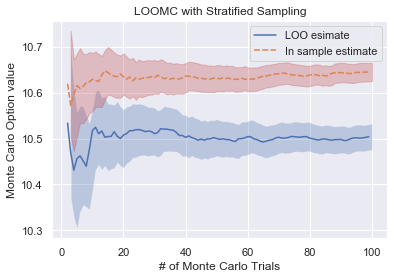

In [133]:
means = np.array([np.mean(sim_loostratified[:i]) for i in range(1,101)])
sd = np.array([np.std(sim_loostratified)/np.sqrt(i) for i in range(1,101)])
means_in = np.array([np.mean(sim_stratified[:i]) for i in range(1,101)])
sd_in = np.array([np.std(sim_stratified)/np.sqrt(i) for i in range(1,101)])

data=pd.DataFrame({'LOO esimate':means,'In sample estimate':means_in})

#95% confidence intervals for simulation results
upper = (means + 2*sd)[2:]
lower = (means - 2*sd)[2:]
upper_in = (means_in + 2*sd_in)[2:]
lower_in = (means_in - 2*sd_in)[2:]

xcord = [i for i in range(3,101)]
sns.set(style='darkgrid')
fig = sns.lineplot(data=data.iloc[2:,])
fig.fill_between(xcord, lower, upper, alpha=.3)
fig.fill_between(xcord, lower_in, upper_in, alpha=.3,color='r')

plt.xlabel("# of Monte Carlo Trials")
plt.ylabel("Monte Carlo Option value")
plt.title("LOOMC with Stratified Sampling")

# In sample estimated Monte Carlo pricing function for american options implemented with Latin Hypercube Sampling and Merton's Jump Diffusion Model

In [61]:
def lhs_option_value_american_merton_lsm(k, r, npath=500, call=True, **kwargs):
    # for robustness, force npath>=500
    npath = 500 if npath < 500 else npath
    # pass prevalent parameters from kwargs
    t = kwargs.get('t',1.0)
    h = kwargs.get('h',1/252)
    
    # length of paths
    n = int(np.floor(t/h))
    # sample of stock paths
    paths = stock_merton_lhs(npath,**kwargs)
        
    
    # initialize 2d array storing cashflows
    cash_flow = np.zeros((npath,n))
    
       # calculate call option value
    if call == 1:
        # payoff at end node
        cash_flow[:,-1] = ((paths[:,-1]-k)>0)*(paths[:,-1]-k)
        
        for i in range(n-1):
    
            # continuation value initializtion
            discount = list(map(lambda x: np.exp(-r*h*x), range(1,i+2)))
            price = paths[:,-2-i]
            cv = (cash_flow[:,(n-i-1):n]*discount).sum(axis=1)*(price > k)
                
            # esitmate cv with polynomial regression of degree 3, if price>k 
            # holds for less than 4 nodes, run regression with lower degrees
            # we don't need cv for out-of-money nodes due to no early exercise
            cv_reg = cv[price > k] #regression independent variable
            x = price[price > k]

            if len(cv_reg) > 4:
                A = np.array([np.ones(len(x)),x,x**2,x**3]).transpose() #design matrix
                clf = linear_model.LinearRegression(fit_intercept=False)
                clf.fit(A, cv_reg)                              
                betahat = clf.coef_
                #betahat = np.linalg.lstsq(A,cv_reg,rcond=None)[0] #coefficients
                cv = (betahat*np.array([np.ones(npath),price,price**2,price**3
                                       ]).transpose()).sum(axis=1)*(price > k)
                
            elif len(cv_reg) == 4:
                A = np.array([np.ones(len(x)),x,x**2]).transpose() #design matrix
                clf = linear_model.LinearRegression(fit_intercept=False)
                clf.fit(A, cv_reg)                              
                betahat = clf.coef_
                #betahat = np.linalg.lstsq(A,cv_reg,rcond=None)[0] #coefficients
                cv = (betahat*np.array([np.ones(npath),price,price**2
                                       ]).transpose()).sum(axis=1)*(price > k)
            elif len(cv_reg) == 3:
                A = np.array([np.ones(len(x)),x]).transpose() #design matrix
                clf = linear_model.LinearRegression(fit_intercept=False)
                clf.fit(A, cv_reg)                              
                betahat = clf.coef_
                #betahat = np.linalg.lstsq(A,cv_reg,rcond=None)[0] #coefficients
                cv = (betahat*np.array([np.ones(npath),price
                                       ]).transpose()).sum(axis=1)*(price > k)
            elif len(cv_reg) > 0:
                cv = np.mean(cv_reg)*(price > k)
                
            # assign cashflow of payoff/0 depending on whether early exercise
            # if early exercise, subsequent cashflow in the path is assigned 0
            cash_flow[:,-2-i] = (price-k)*(price - k - cv > 0)
            early_node = np.array(range(npath))*(cash_flow[:,-2-i] > 0)
            early_index = early_node[early_node > 0]
            
            for j in early_index:
                cash_flow[j,(n-i-1):n] = 0
        
        # discount cash flow to present to get the option value
        discount = list(map(lambda x: np.exp(-r*h*x), range(1,n+1)))
        value = (cash_flow*discount).sum()/npath
        
        
    # calculate put option value
    else:
        # payoff at end node
        cash_flow[:,-1] = ((k-paths[:,-1])>0)*(k-paths[:,-1])
        
        for i in range(n-1):
    
            # continuation value initializtion
            discount = list(map(lambda x: np.exp(-r*h*x), range(1,i+2)))
            price = paths[:,-2-i]
            cv = (cash_flow[:,(n-i-1):n]*discount).sum(axis=1)*(price < k)
                
            # esitmate cv with polynomial regression of degree 3, if price<k 
            # holds for less than 4 nodes, run regression with lower degrees
            # we don't need cv for out-of-money nodes due to no early exercise
            
            cv_reg = cv[price < k] #regression independent variable
            x = price[price < k]
            if len(cv_reg) > 4:
                A = np.array([np.ones(len(x)),x,x**2,x**3]).transpose() 
                clf = linear_model.LinearRegression(fit_intercept=False)
                clf.fit(A, cv_reg)                              
                betahat = clf.coef_
                #betahat = np.linalg.lstsq(A,cv_reg,rcond=None)[0] #coefficients
                cv = (betahat*np.array([np.ones(npath),price,price**2,price**3
                                       ]).transpose()).sum(axis=1)*(price < k) 
               
            elif len(cv_reg) == 4:
                A = np.array([np.ones(len(x)),x,x**2]).transpose() 
                clf = linear_model.LinearRegression(fit_intercept=False)
                clf.fit(A, cv_reg)                              
                betahat = clf.coef_
                #betahat = np.linalg.lstsq(A,cv_reg,rcond=None)[0] #coefficients
                cv = (betahat*np.array([np.ones(npath),price,price**2
                                       ]).transpose()).sum(axis=1)*(price < k)
            elif len(cv_reg) == 3:
                A = np.array([np.ones(len(x)),x]).transpose() 
                clf = linear_model.LinearRegression(fit_intercept=False)
                clf.fit(A, cv_reg)                              
                betahat = clf.coef_
                #betahat = np.linalg.lstsq(A,cv_reg,rcond=None)[0] #coefficients
                cv = (betahat*np.array([np.ones(npath),price
                                       ]).transpose()).sum(axis=1)*(price < k)
            elif len(cv_reg) > 0:
                cv = np.mean(cv_reg)*(price < k)

               
            # assign cashflow of payoff/0 depending on whether early exercise
            # if early exercise, subsequent cashflow in the path is 0
            cash_flow[:,-2-i] = (k - price)*(k - price - cv > 0)
            early_node = np.array(range(npath))*(cash_flow[:,-2-i] > 0)
            early_index = early_node[early_node > 0]
            
            for j in early_index:
                cash_flow[j,(n-i-1):n] = 0
        
        # discount cash flow to present to get the option value
        discount = list(map(lambda x: np.exp(-r*h*x), range(1,n+1)))
        value = (cash_flow*discount).sum()/npath       
        
    
    return value


#Stock paths with Merton's Jump Disffusion model and Latin Hypercube Sampling

def stock_merton_lhs(npath, alpha, delta, lambda_, sigma, alpha_j, sigma_j, 
                     h=1/252, t=1, s=100):
    
    n=int(t/h)
    paths = np.zeros((npath,n+1))
    #lhs for w,z,m
    design = lhs(3,samples=n*npath)
    w = norm.ppf(design[:,0])
    z = norm.ppf(design[:,1])
    m = poisson.ppf(design[:,2],mu=lambda_*h)
    for i in range(npath):
        compound = np.exp((alpha - delta - lambda_*alpha_j - sigma**2/2-lambda_*sigma_j**2/2)*h +
                          sigma*np.sqrt(h)*w[(n*i):(n*i+n)] + m[(n*i):(n*i+n)]*alpha_j +
                          sigma_j*m[(n*i):(n*i+n)]*z[(n*i):(n*i+n)])
        paths[i][:] = np.cumprod([s]+compound.flatten().tolist())
   
    return paths

In [42]:
np.random.seed(2020)
kwargs = {'alpha':0.03, 'delta':0, 'sigma':0.3, 'alpha_j':-0.02,'sigma_j':0.05,'lambda_':5,'t':1/12, 's':100}

lhs_option_value_american_merton_lsm(110,0.03,call=False,**kwargs)

10.989222158481784

In [43]:
np.random.seed(2020)
sim_lhs_merton_lsm = [lhs_option_value_american_merton_lsm(110,0.03,call=False,npath=1000,**kwargs) for i in range(100)]

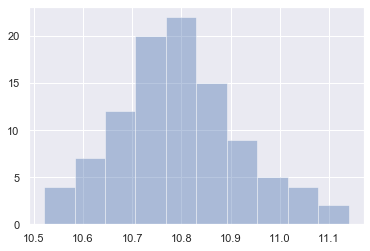

In [44]:
sns.set_style('darkgrid')

ax=sns.distplot(sim_lhs_merton_lsm,kde=False)



# LOO Monte Carlo pricing function for american options implemented with Latin Hypercube Sampling and Merton's Jump Diffusion Model

In [45]:
# Efficient Monte Carlo pricing function for american options implemented 
# with LHS and Merton's Jump Diffusion stock price model, with OOSLS

def lhs_option_value_american_merton(k, r, npath=500, call=True, **kwargs):
    # for robustness, force npath>=500
    npath = 500 if npath < 500 else npath
    # pass prevalent parameters from kwargs
    t = kwargs.get('t',1.0)
    h = kwargs.get('h',1/252)
    
    # length of paths
    n = int(np.floor(t/h))
    # sample of stock paths
    paths = stock_merton_lhs(npath,**kwargs)
        
    
    # initialize 2d array storing cashflows
    cash_flow = np.zeros((npath,n))
    
       # calculate call option value
    if call == 1:
        # payoff at end node
        cash_flow[:,-1] = ((paths[:,-1]-k)>0)*(paths[:,-1]-k)
        
        for i in range(n-1):
    
            # continuation value initializtion
            discount = list(map(lambda x: np.exp(-r*h*x), range(1,i+2)))
            price = paths[:,-2-i]
            cv = (cash_flow[:,(n-i-1):n]*discount).sum(axis=1)*(price > k)
                
            # esitmate cv with polynomial regression of degree 3, if price>k 
            # holds for less than 4 nodes, run regression with lower degrees
            # we don't need cv for out-of-money nodes due to no early exercise
            
            cv_reg = cv[price > k] #regression independent variable
            x = price[price > k]
            if len(cv_reg) > 4:
                #LOO regression
                betahat = np.zeros((npath,4))
                l = 0
                for j in range(npath):
                    if price[j]>k:
                        cv_loo = np.array(cv_reg.tolist()[:l]+cv_reg.tolist()[(l+1):])
                        x_loo = np.array(x.tolist()[:l]+x.tolist()[(l+1):])
                        A = np.array([np.ones(len(x_loo)),x_loo,x_loo**2,x_loo**3]).transpose() #design matrix
                        clf = linear_model.LinearRegression(fit_intercept=False)
                        clf.fit(A, cv_loo)                              
                        betahat[j] = clf.coef_
                        l+=1
                   
                cv = (betahat*np.array([np.ones(npath),price,price**2,price**3
                                       ]).transpose()).sum(axis=1)*(price > k)    
            elif len(cv_reg) == 4:
                #LOO regression
                betahat = np.zeros((npath,3))
                l = 0
                for j in range(npath):
                    if price[j]>k:
                        cv_loo = np.array(cv_reg.tolist()[:l]+cv_reg.tolist()[(l+1):])
                        x_loo = np.array(x.tolist()[:l]+x.tolist()[(l+1):])
                        A = np.array([np.ones(len(x_loo)),x_loo,x_loo**2]).transpose() #design matrix
                        clf = linear_model.LinearRegression(fit_intercept=False)
                        clf.fit(A, cv_loo)                              
                        betahat[j] = clf.coef_
                        l+=1
                   
                cv = (betahat*np.array([np.ones(npath),price,price**2,
                                       ]).transpose()).sum(axis=1)*(price > k)    

            elif len(cv_reg) == 3:
                betahat = np.zeros((npath,2))
                l = 0
                for j in range(npath):
                    if price[j]>k:
                        cv_loo = np.array(cv_reg.tolist()[:l]+cv_reg.tolist()[(l+1):])
                        x_loo = np.array(x.tolist()[:l]+x.tolist()[(l+1):])
                        A = np.array([np.ones(len(x_loo)),x_loo]).transpose() #design matrix
                        clf = linear_model.LinearRegression(fit_intercept=False)
                        clf.fit(A, cv_loo)                              
                        betahat[j] = clf.coef_
                        l+=1
                   
                cv = (betahat*np.array([np.ones(npath),price,
                                       ]).transpose()).sum(axis=1)*(price > k)    


            elif len(cv_reg) > 0:
                cv = np.mean(cv_reg)*(price > k)
                
            # assign cashflow of payoff/0 depending on whether early exercise
            # if early exercise, subsequent cashflow in the path is assigned 0
            cash_flow[:,-2-i] = (price-k)*(price - k - cv > 0)
            early_node = np.array(range(npath))*(cash_flow[:,-2-i] > 0)
            early_index = early_node[early_node > 0]
            
            for j in early_index:
                cash_flow[j,(n-i-1):n] = 0
        
        # discount cash flow to present to get the option value
        discount = list(map(lambda x: np.exp(-r*h*x), range(1,n+1)))
        value = (cash_flow*discount).sum()/npath
        
        
    # calculate put option value
    else:
        # payoff at end node
        cash_flow[:,-1] = ((k-paths[:,-1])>0)*(k-paths[:,-1])
        
        for i in range(n-1):
    
            # continuation value initializtion
            discount = list(map(lambda x: np.exp(-r*h*x), range(1,i+2)))
            price = paths[:,-2-i]
            cv = (cash_flow[:,(n-i-1):n]*discount).sum(axis=1)*(price < k)
                
            # esitmate cv with polynomial regression of degree 3, if price<k 
            # holds for less than 4 nodes, run regression with lower degrees
            # we don't need cv for out-of-money nodes due to no early exercise
            
            cv_reg = cv[price < k] #regression independent variable
            x = price[price < k]
            if len(cv_reg) > 4:
                #LOO regression
                betahat = np.zeros((npath,4))
                l = 0
                for j in range(npath):
                    if price[j]<k:
                        cv_loo = np.array(cv_reg.tolist()[:l]+cv_reg.tolist()[(l+1):])
                        x_loo = np.array(x.tolist()[:l]+x.tolist()[(l+1):])
                        A = np.array([np.ones(len(x_loo)),x_loo,x_loo**2,x_loo**3]).transpose() #design matrix
                        clf = linear_model.LinearRegression(fit_intercept=False)
                        clf.fit(A, cv_loo)                              
                        betahat[j] = clf.coef_
                        l+=1
                   
                cv = (betahat*np.array([np.ones(npath),price,price**2,price**3
                                       ]).transpose()).sum(axis=1)*(price < k)    
            elif len(cv_reg) == 4:
                #LOO regression
                betahat = np.zeros((npath,3))
                l = 0
                for j in range(npath):
                    if price[j]<k:
                        cv_loo = np.array(cv_reg.tolist()[:l]+cv_reg.tolist()[(l+1):])
                        x_loo = np.array(x.tolist()[:l]+x.tolist()[(l+1):])
                        A = np.array([np.ones(len(x_loo)),x_loo,x_loo**2]).transpose() #design matrix
                        clf = linear_model.LinearRegression(fit_intercept=False)
                        clf.fit(A, cv_loo)                              
                        betahat[j] = clf.coef_
                        l+=1
                   
                cv = (betahat*np.array([np.ones(npath),price,price**2,
                                       ]).transpose()).sum(axis=1)*(price > k)    

            elif len(cv_reg) == 3:
                betahat = np.zeros((npath,2))
                l = 0
                for j in range(npath):
                    if price[j]<k:
                        cv_loo = np.array(cv_reg.tolist()[:l]+cv_reg.tolist()[(l+1):])
                        x_loo = np.array(x.tolist()[:l]+x.tolist()[(l+1):])
                        A = np.array([np.ones(len(x_loo)),x_loo]).transpose() #design matrix
                        clf = linear_model.LinearRegression(fit_intercept=False)
                        clf.fit(A, cv_loo)                              
                        betahat[j] = clf.coef_
                        l+=1
                   
                cv = (betahat*np.array([np.ones(npath),price,
                                       ]).transpose()).sum(axis=1)*(price < k)    


            elif len(cv_reg) > 0:
                cv = np.mean(cv_reg)*(price < k)
                
            # assign cashflow of payoff/0 depending on whether early exercise
            # if early exercise, subsequent cashflow in the path is 0
            cash_flow[:,-2-i] = (k - price)*(k - price - cv > 0)
            early_node = np.array(range(npath))*(cash_flow[:,-2-i] > 0)
            early_index = early_node[early_node > 0]
            
            for j in early_index:
                cash_flow[j,(n-i-1):n] = 0
        
        # discount cash flow to present to get the option value
        discount = list(map(lambda x: np.exp(-r*h*x), range(1,n+1)))
        value = (cash_flow*discount).sum()/npath       
        
    
    return value


#Stock paths with Merton's Jump Disffusion model and Latin Hypercube Sampling

def stock_merton_lhs(npath, alpha, delta, lambda_, sigma, alpha_j, sigma_j, 
                     h=1/252, t=1, s=100):
    
    n=int(t/h)
    paths = np.zeros((npath,n+1))
    #lhs for w,z,m
    design = lhs(3,samples=n*npath)
    w = norm.ppf(design[:,0])
    z = norm.ppf(design[:,1])
    m = poisson.ppf(design[:,2],mu=lambda_*h)
    for i in range(npath):
        compound = np.exp((alpha - delta - lambda_*alpha_j - sigma**2/2-lambda_*sigma_j**2/2)*h +
                          sigma*np.sqrt(h)*w[(n*i):(n*i+n)] + m[(n*i):(n*i+n)]*alpha_j +
                          sigma_j*m[(n*i):(n*i+n)]*z[(n*i):(n*i+n)])
        paths[i][:] = np.cumprod([s]+compound.flatten().tolist())
   
    return paths

In [46]:
np.random.seed(2020)
kwargs = {'alpha':0.03, 'delta':0, 'sigma':0.3, 'alpha_j':-0.02,'sigma_j':0.05,'lambda_':5,'t':1/12, 's':100}

lhs_option_value_american_merton(110,0.03,call=False,**kwargs)

11.0270649617899

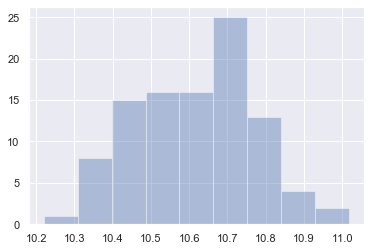

In [47]:
# LOOMC estimate of merton's model
np.random.seed(2020)
sim_lhs_merton = [lhs_option_value_american_merton(110,0.03,call=False,npath=1000,**kwargs) for i in range(100)]

sns.set_style('darkgrid')

ax=sns.distplot(sim_lhs_merton,kde=False)


Text(0.5, 1.0, "LOOMC with LHS for Merton's Jump Diffusion")

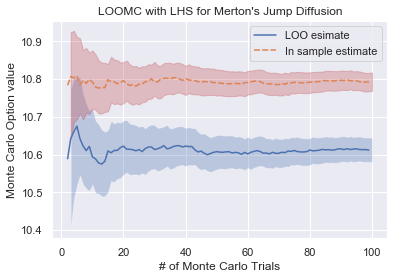

In [132]:
#Monte Carlo estimates with different sample size for Merton's Jump Diffusion model
#Both LOO and in sample estimates are shown with a 95% confidence interval 
means = np.array([np.mean(sim_lhs_merton[:i]) for i in range(1,101)])
sd = np.array([np.std(sim_lhs_merton)/np.sqrt(i) for i in range(1,101)])
means_in = np.array([np.mean(sim_lhs_merton_lsm[:i]) for i in range(1,101)])
sd_in = np.array([np.std(sim_lhs_merton_lsm)/np.sqrt(i) for i in range(1,101)])
data=pd.DataFrame({'LOO esimate':means,'In sample estimate':means_in})

#95% confidence intervals for simulation results
upper = (means + 2*sd)[2:]
lower = (means - 2*sd)[2:]
upper_in = (means_in + 2*sd_in)[2:]
lower_in = (means_in - 2*sd_in)[2:]

xcord = [i for i in range(3,101)]
sns.set(style='darkgrid')
fig = sns.lineplot(data=data.iloc[2:,])
fig.fill_between(xcord, lower, upper, alpha=.3)
fig.fill_between(xcord, lower_in, upper_in, alpha=.3,color='r')


plt.xlabel("# of Monte Carlo Trials")
plt.ylabel("Monte Carlo Option value")
plt.title("LOOMC with LHS for Merton's Jump Diffusion")

# In Sample Estimated Monte Carlo pricing function for american options implemented with LHS and Kou's Jump Diffusion Model

In [49]:
# Efficient Monte Carlo pricing function for american options implemented 
# with LHS and Kou's Jump Diffusion stock price model, with in sample OLS

def lhs_option_value_american_kou_lsm(k, r, npath=500, call=True, **kwargs):
    # for robustness, force npath>=500
    npath = 500 if npath < 500 else npath
    # pass prevalent parameters from kwargs
    t = kwargs.get('t',1.0)
    h = kwargs.get('h',1/252)
    
    # length of paths
    n = int(np.floor(t/h))
    # sample of stock paths
    paths = stock_kou_lhs(npath,**kwargs)
        
    
    # initialize 2d array storing cashflows
    cash_flow = np.zeros((npath,n))
    
       # calculate call option value
    if call == 1:
        # payoff at end node
        cash_flow[:,-1] = ((paths[:,-1]-k)>0)*(paths[:,-1]-k)
        
        for i in range(n-1):
    
            # continuation value initializtion
            discount = list(map(lambda x: np.exp(-r*h*x), range(1,i+2)))
            price = paths[:,-2-i]
            cv = (cash_flow[:,(n-i-1):n]*discount).sum(axis=1)*(price > k)
                
            # esitmate cv with polynomial regression of degree 3, if price>k 
            # holds for less than 4 nodes, run regression with lower degrees
            # we don't need cv for out-of-money nodes due to no early exercise
            
            cv_reg = cv[price > k] #regression independent variable
            x = price[price > k]
            if len(cv_reg) > 4:
                A = np.array([np.ones(len(x)),x,x**2,x**3]).transpose() #design matrix
                clf = linear_model.LinearRegression(fit_intercept=False)
                clf.fit(A, cv_reg)                              
                betahat = clf.coef_
                #betahat = np.linalg.lstsq(A,cv_reg,rcond=None)[0] #coefficients
                cv = (betahat*np.array([np.ones(npath),price,price**2,price**3
                                       ]).transpose()).sum(axis=1)*(price > k)
                
            elif len(cv_reg) == 4:
                A = np.array([np.ones(len(x)),x,x**2]).transpose() #design matrix
                clf = linear_model.LinearRegression(fit_intercept=False)
                clf.fit(A, cv_reg)                              
                betahat = clf.coef_
                #betahat = np.linalg.lstsq(A,cv_reg,rcond=None)[0] #coefficients
                cv = (betahat*np.array([np.ones(npath),price,price**2
                                       ]).transpose()).sum(axis=1)*(price > k)
            elif len(cv_reg) == 3:
                A = np.array([np.ones(len(x)),x]).transpose() #design matrix
                clf = linear_model.LinearRegression(fit_intercept=False)
                clf.fit(A, cv_reg)                              
                betahat = clf.coef_
                #betahat = np.linalg.lstsq(A,cv_reg,rcond=None)[0] #coefficients
                cv = (betahat*np.array([np.ones(npath),price
                                       ]).transpose()).sum(axis=1)*(price > k)
            elif len(cv_reg) > 0:
                cv = np.mean(cv_reg)*(price > k)
                                
            # assign cashflow of payoff/0 depending on whether early exercise
            # if early exercise, subsequent cashflow in the path is assigned 0
            cash_flow[:,-2-i] = (price-k)*(price - k - cv > 0)
            early_node = np.array(range(npath))*(cash_flow[:,-2-i] > 0)
            early_index = early_node[early_node > 0]
            
            for j in early_index:
                cash_flow[j,(n-i-1):n] = 0
        
        # discount cash flow to present to get the option value
        discount = list(map(lambda x: np.exp(-r*h*x), range(1,n+1)))
        value = (cash_flow*discount).sum()/npath
        
        
    # calculate put option value
    else:
        # payoff at end node
        cash_flow[:,-1] = ((k-paths[:,-1])>0)*(k-paths[:,-1])
        
        for i in range(n-1):
    
            # continuation value initializtion
            discount = list(map(lambda x: np.exp(-r*h*x), range(1,i+2)))
            price = paths[:,-2-i]
            cv = (cash_flow[:,(n-i-1):n]*discount).sum(axis=1)*(price < k)
                
            # esitmate cv with polynomial regression of degree 3, if price<k 
            # holds for less than 4 nodes, run regression with lower degrees
            # we don't need cv for out-of-money nodes due to no early exercise
            
            cv_reg = cv[price < k] #regression independent variable
            x = price[price < k]
            if len(cv_reg) > 4:
                A = np.array([np.ones(len(x)),x,x**2,x**3]).transpose() 
                clf = linear_model.LinearRegression(fit_intercept=False)
                clf.fit(A, cv_reg)                              
                betahat = clf.coef_
                #betahat = np.linalg.lstsq(A,cv_reg,rcond=None)[0] #coefficients
                cv = (betahat*np.array([np.ones(npath),price,price**2,price**3
                                       ]).transpose()).sum(axis=1)*(price < k) 
               
            elif len(cv_reg) == 4:
                A = np.array([np.ones(len(x)),x,x**2]).transpose() 
                clf = linear_model.LinearRegression(fit_intercept=False)
                clf.fit(A, cv_reg)                              
                betahat = clf.coef_
                #betahat = np.linalg.lstsq(A,cv_reg,rcond=None)[0] #coefficients
                cv = (betahat*np.array([np.ones(npath),price,price**2
                                       ]).transpose()).sum(axis=1)*(price < k)
            elif len(cv_reg) == 3:
                A = np.array([np.ones(len(x)),x]).transpose() 
                clf = linear_model.LinearRegression(fit_intercept=False)
                clf.fit(A, cv_reg)                              
                betahat = clf.coef_
                #betahat = np.linalg.lstsq(A,cv_reg,rcond=None)[0] #coefficients
                cv = (betahat*np.array([np.ones(npath),price
                                       ]).transpose()).sum(axis=1)*(price < k)
            elif len(cv_reg) > 0:
                cv = np.mean(cv_reg)*(price < k)

            
            # assign cashflow of payoff/0 depending on whether early exercise
            # if early exercise, subsequent cashflow in the path is 0
            cash_flow[:,-2-i] = (k - price)*(k - price - cv > 0)
            early_node = np.array(range(npath))*(cash_flow[:,-2-i] > 0)
            early_index = early_node[early_node > 0]
            
            for j in early_index:
                cash_flow[j,(n-i-1):n] = 0
        
        # discount cash flow to present to get the option value
        discount = list(map(lambda x: np.exp(-r*h*x), range(1,n+1)))
        value = (cash_flow*discount).sum()/npath       
        
    
    return value


#Stock paths with Kou's Jump Disffusion model and Latin Hypercube Sampling

def stock_kou_lhs(npath, alpha, delta, lambda_, sigma, p, eta1, eta2, 
                     h=1/252, t=1, s=100):
    q=1-p
    n=int(t/h)
    paths = np.zeros((npath,n+1))
    #lhs for w,y,m
    design = lhs(3,samples=n*npath)
    w = norm.ppf(design[:,0])
    y = pd.Series(design[:,1]).apply(lambda x:ppf_double_exponential(x,p,eta1,eta2))
    m = poisson.ppf(design[:,2],mu=lambda_*h)
    for i in range(npath):
        zeta = p*eta1/(eta1-1)+q*eta2/(eta2+1)-1
        compound = np.exp((alpha - delta - lambda_*zeta - sigma**2/2)*h +
                          sigma*np.sqrt(h)*w[(n*i):(n*i+n)] + m[(n*i):(n*i+n)]*y[(n*i):(n*i+n)])
        paths[i][:] = np.cumprod([s]+compound.tolist())
   
    return paths
# inverse function for double exponenital CDF
def ppf_double_exponential(y,p,eta1,eta2):
    q=1-p
    if y<q:
        x = np.log(y/q)/eta2
    else:
        x = - np.log((1-y)/p)/eta1
    
    return x

In [50]:
np.random.seed(2020)
kwargs = {'alpha':0.03, 'delta':0, 'sigma':0.3, 'lambda_':5, 
          'p':0.4, 'eta1':20, 'eta2':10, 't':1/12, 's':100}

lhs_option_value_american_kou_lsm(110,0.03,call=False,**kwargs)

11.474350690945524

# LOO Monte Carlo pricing function for american options implemented with antithetic variate method and Kou's Jump Diffusion Model

In [51]:
# Efficient Monte Carlo pricing function for american options implemented 
# with LHS and Kou's Jump Diffusion stock price model, with LOOLS

def lhs_option_value_american_kou(k, r, npath=500, call=True, **kwargs):
    # for robustness, force npath>=500
    npath = 500 if npath < 500 else npath
    # pass prevalent parameters from kwargs
    t = kwargs.get('t',1.0)
    h = kwargs.get('h',1/252)
    
    # length of paths
    n = int(np.floor(t/h))
    # sample of stock paths
    paths = stock_kou_lhs(npath,**kwargs)
        
    
    # initialize 2d array storing cashflows
    cash_flow = np.zeros((npath,n))
    
       # calculate call option value
    if call == 1:
        # payoff at end node
        cash_flow[:,-1] = ((paths[:,-1]-k)>0)*(paths[:,-1]-k)
        
        for i in range(n-1):
    
            # continuation value initializtion
            discount = list(map(lambda x: np.exp(-r*h*x), range(1,i+2)))
            price = paths[:,-2-i]
            cv = (cash_flow[:,(n-i-1):n]*discount).sum(axis=1)*(price > k)
                
            # esitmate cv with polynomial regression of degree 3, if price>k 
            # holds for less than 4 nodes, run regression with lower degrees
            # we don't need cv for out-of-money nodes due to no early exercise
            
            cv_reg = cv[price > k] #regression independent variable
            x = price[price > k]
            if len(cv_reg) > 4:
                #LOO regression
                betahat = np.zeros((npath,4))
                l = 0
                for j in range(npath):
                    if price[j]>k:
                        cv_loo = np.array(cv_reg.tolist()[:l]+cv_reg.tolist()[(l+1):])
                        x_loo = np.array(x.tolist()[:l]+x.tolist()[(l+1):])
                        A = np.array([np.ones(len(x_loo)),x_loo,x_loo**2,x_loo**3]).transpose() #design matrix
                        clf = linear_model.LinearRegression(fit_intercept=False)
                        clf.fit(A, cv_loo)                              
                        betahat[j] = clf.coef_
                        l+=1
                   
                cv = (betahat*np.array([np.ones(npath),price,price**2,price**3
                                       ]).transpose()).sum(axis=1)*(price > k)    
            elif len(cv_reg) == 4:
                #LOO regression
                betahat = np.zeros((npath,3))
                l = 0
                for j in range(npath):
                    if price[j]>k:
                        cv_loo = np.array(cv_reg.tolist()[:l]+cv_reg.tolist()[(l+1):])
                        x_loo = np.array(x.tolist()[:l]+x.tolist()[(l+1):])
                        A = np.array([np.ones(len(x_loo)),x_loo,x_loo**2]).transpose() #design matrix
                        clf = linear_model.LinearRegression(fit_intercept=False)
                        clf.fit(A, cv_loo)                              
                        betahat[j] = clf.coef_
                        l+=1
                   
                cv = (betahat*np.array([np.ones(npath),price,price**2,
                                       ]).transpose()).sum(axis=1)*(price > k)    

            elif len(cv_reg) == 3:
                betahat = np.zeros((npath,2))
                l = 0
                for j in range(npath):
                    if price[j]>k:
                        cv_loo = np.array(cv_reg.tolist()[:l]+cv_reg.tolist()[(l+1):])
                        x_loo = np.array(x.tolist()[:l]+x.tolist()[(l+1):])
                        A = np.array([np.ones(len(x_loo)),x_loo]).transpose() #design matrix
                        clf = linear_model.LinearRegression(fit_intercept=False)
                        clf.fit(A, cv_loo)                              
                        betahat[j] = clf.coef_
                        l+=1
                   
                cv = (betahat*np.array([np.ones(npath),price,
                                       ]).transpose()).sum(axis=1)*(price > k)    


            elif len(cv_reg) > 0:
                cv = np.mean(cv_reg)*(price > k)
                
            # assign cashflow of payoff/0 depending on whether early exercise
            # if early exercise, subsequent cashflow in the path is assigned 0
            cash_flow[:,-2-i] = (price-k)*(price - k - cv > 0)
            early_node = np.array(range(npath))*(cash_flow[:,-2-i] > 0)
            early_index = early_node[early_node > 0]
            
            for j in early_index:
                cash_flow[j,(n-i-1):n] = 0
        
        # discount cash flow to present to get the option value
        discount = list(map(lambda x: np.exp(-r*h*x), range(1,n+1)))
        value = (cash_flow*discount).sum()/npath
        
        
    # calculate put option value
    else:
        # payoff at end node
        cash_flow[:,-1] = ((k-paths[:,-1])>0)*(k-paths[:,-1])
        
        for i in range(n-1):
    
            # continuation value initializtion
            discount = list(map(lambda x: np.exp(-r*h*x), range(1,i+2)))
            price = paths[:,-2-i]
            cv = (cash_flow[:,(n-i-1):n]*discount).sum(axis=1)*(price < k)
                
            # esitmate cv with polynomial regression of degree 3, if price<k 
            # holds for less than 4 nodes, run regression with lower degrees
            # we don't need cv for out-of-money nodes due to no early exercise
            
            cv_reg = cv[price < k] #regression independent variable
            x = price[price < k]
            if len(cv_reg) > 4:
                #LOO regression
                betahat = np.zeros((npath,4))
                l = 0
                for j in range(npath):
                    if price[j]<k:
                        cv_loo = np.array(cv_reg.tolist()[:l]+cv_reg.tolist()[(l+1):])
                        x_loo = np.array(x.tolist()[:l]+x.tolist()[(l+1):])
                        A = np.array([np.ones(len(x_loo)),x_loo,x_loo**2,x_loo**3]).transpose() #design matrix
                        clf = linear_model.LinearRegression(fit_intercept=False)
                        clf.fit(A, cv_loo)                              
                        betahat[j] = clf.coef_
                        l+=1
                   
                cv = (betahat*np.array([np.ones(npath),price,price**2,price**3
                                       ]).transpose()).sum(axis=1)*(price < k)    
            elif len(cv_reg) == 4:
                #LOO regression
                betahat = np.zeros((npath,3))
                l = 0
                for j in range(npath):
                    if price[j]<k:
                        cv_loo = np.array(cv_reg.tolist()[:l]+cv_reg.tolist()[(l+1):])
                        x_loo = np.array(x.tolist()[:l]+x.tolist()[(l+1):])
                        A = np.array([np.ones(len(x_loo)),x_loo,x_loo**2]).transpose() #design matrix
                        clf = linear_model.LinearRegression(fit_intercept=False)
                        clf.fit(A, cv_loo)                              
                        betahat[j] = clf.coef_
                        l+=1
                   
                cv = (betahat*np.array([np.ones(npath),price,price**2,
                                       ]).transpose()).sum(axis=1)*(price > k)    

            elif len(cv_reg) == 3:
                betahat = np.zeros((npath,2))
                l = 0
                for j in range(npath):
                    if price[j]<k:
                        cv_loo = np.array(cv_reg.tolist()[:l]+cv_reg.tolist()[(l+1):])
                        x_loo = np.array(x.tolist()[:l]+x.tolist()[(l+1):])
                        A = np.array([np.ones(len(x_loo)),x_loo]).transpose() #design matrix
                        clf = linear_model.LinearRegression(fit_intercept=False)
                        clf.fit(A, cv_loo)                              
                        betahat[j] = clf.coef_
                        l+=1
                   
                cv = (betahat*np.array([np.ones(npath),price,
                                       ]).transpose()).sum(axis=1)*(price < k)    


            elif len(cv_reg) > 0:
                cv = np.mean(cv_reg)*(price < k)
                
            # assign cashflow of payoff/0 depending on whether early exercise
            # if early exercise, subsequent cashflow in the path is 0
            cash_flow[:,-2-i] = (k - price)*(k - price - cv > 0)
            early_node = np.array(range(npath))*(cash_flow[:,-2-i] > 0)
            early_index = early_node[early_node > 0]
            
            for j in early_index:
                cash_flow[j,(n-i-1):n] = 0
        
        # discount cash flow to present to get the option value
        discount = list(map(lambda x: np.exp(-r*h*x), range(1,n+1)))
        value = (cash_flow*discount).sum()/npath       
        
    
    return value


#Stock paths with Kou's Jump Disffusion model and Latin Hypercube Sampling

def stock_kou_lhs(npath, alpha, delta, lambda_, sigma, p, eta1, eta2, 
                     h=1/252, t=1, s=100):
    q=1-p
    n=int(t/h)
    paths = np.zeros((npath,n+1))
    #lhs for w,y,m
    design = lhs(3,samples=n*npath)
    w = norm.ppf(design[:,0])
    y = pd.Series(design[:,1]).apply(lambda x:ppf_double_exponential(x,p,eta1,eta2))
    m = poisson.ppf(design[:,2],mu=lambda_*h)
    for i in range(npath):
        zeta = p*eta1/(eta1-1)+q*eta2/(eta2+1)-1
        compound = np.exp((alpha - delta - lambda_*zeta - sigma**2/2)*h +
                          sigma*np.sqrt(h)*w[(n*i):(n*i+n)] + m[(n*i):(n*i+n)]*y[(n*i):(n*i+n)])
        paths[i][:] = np.cumprod([s]+compound.tolist())
   
    return paths
# inverse function for double exponenital CDF
def ppf_double_exponential(y,p,eta1,eta2):
    q=1-p
    if y<q:
        x = np.log(y/q)/eta2
    else:
        x = - np.log((1-y)/p)/eta1
    
    return x

In [52]:
np.random.seed(2020)
kwargs = {'alpha':0.03, 'delta':0, 'sigma':0.3, 'lambda_':5, 
          'p':0.4, 'eta1':20, 'eta2':10, 't':1/12, 's':100}

lhs_option_value_american_kou(110,0.03,call=False,**kwargs)

11.219147319942916

# Try multipleprocessing to cut down the runtime of LOOMC

In [53]:
# get an idea of the runtime for LOOMC
np.random.seed(2020)
start = timeit.default_timer()
test1 =np.array([lhs_option_value_american_kou(110,0.03,npath=1000,call=False,**kwargs) for i in range(100)])
stop = timeit.default_timer()
print('Time: ',stop - start)

Time:  857.9793152999998


In [54]:
# test out multiprosessing for Monte Carlo simulations for LOOMC
np.random.seed(2020)
start = timeit.default_timer()
if __name__=="__main__":
    p=Pool(6)
    test2 = [p.apply_async(lhs_option_value_american_kou(110,0.03,npath=1000,call=False,**kwargs)) for i in range(100)]

    result = [f.get for f in test2]
stop = timeit.default_timer()
print('Time: ',stop - start)

Time:  851.7718451999999


In [55]:
# get an idea of how much time in sample estimate takes
np.random.seed(2020)
start = timeit.default_timer()
sim_lhs_kou_lsm = [lhs_option_value_american_kou_lsm(110,0.03,call=False,npath=1000,**kwargs) for i in range(100)]
stop = timeit.default_timer()
print('Time: ',stop - start)



Time:  39.07019410000021


In [56]:
## DID NOT WORK! THANKS PYHTON! Global Interpreter Lock for the win! Way to go!

Text(0.5, 1.0, "LOOMC with LHS for Kou's Jump Diffusion")

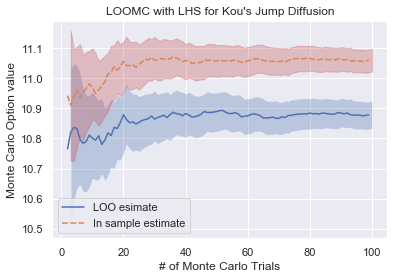

In [131]:
sim_lhs_kou = test1
means = np.array([np.mean(sim_lhs_kou[:i]) for i in range(1,101)])
sd = np.array([np.std(sim_lhs_kou)/np.sqrt(i) for i in range(1,101)])
means_in = np.array([np.mean(sim_lhs_kou_lsm[:i]) for i in range(1,101)])
sd_in = np.array([np.std(sim_lhs_kou_lsm)/np.sqrt(i) for i in range(1,101)])
data=pd.DataFrame({'LOO esimate':means,'In sample estimate':means_in})

#95% confidence intervals for simulation results
upper = (means + 2*sd)[2:]
lower = (means - 2*sd)[2:]
upper_in = (means_in + 2*sd_in)[2:]
lower_in = (means_in - 2*sd_in)[2:]

xcord = [i for i in range(3,101)]
sns.set(style='darkgrid')
fig = sns.lineplot(data=data.iloc[2:,])
fig.fill_between(xcord, lower, upper, alpha=.3)
fig.fill_between(xcord, lower_in, upper_in, alpha=.3,color='r')

plt.xlabel("# of Monte Carlo Trials")
plt.ylabel("Monte Carlo Option value")
plt.title("LOOMC with LHS for Kou's Jump Diffusion")

# Numerical results for ITM/OTM American put/call options

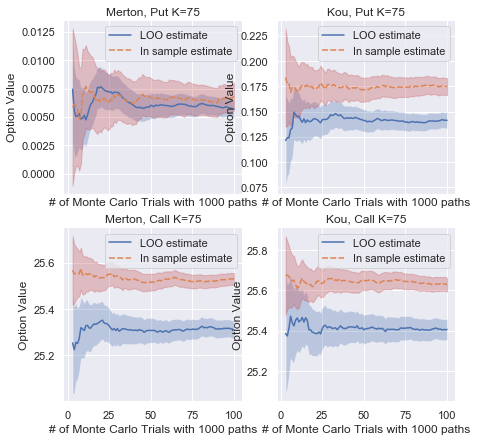

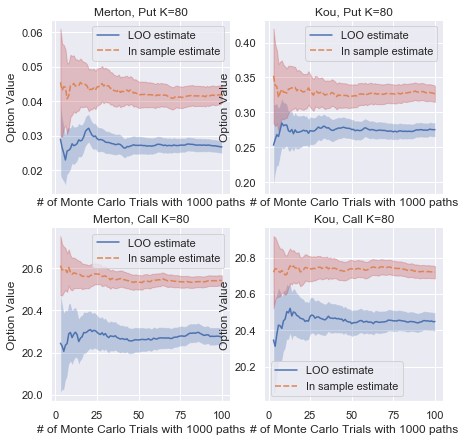

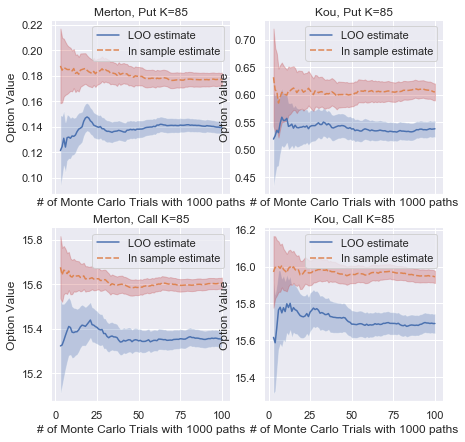

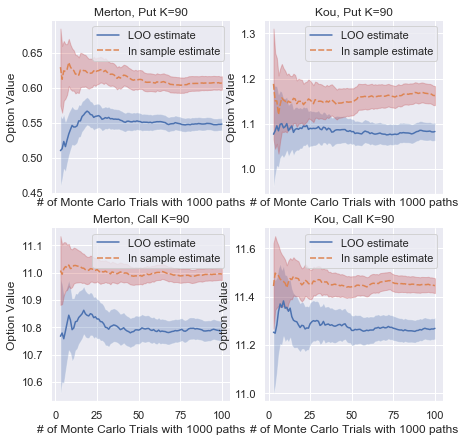

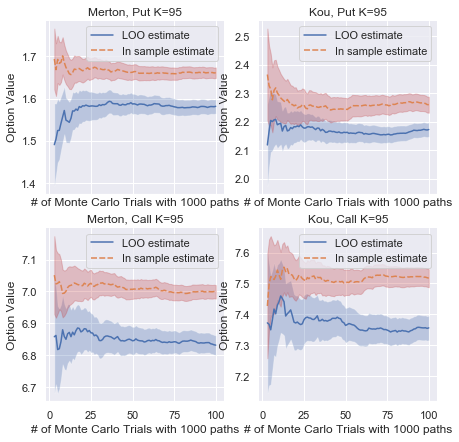

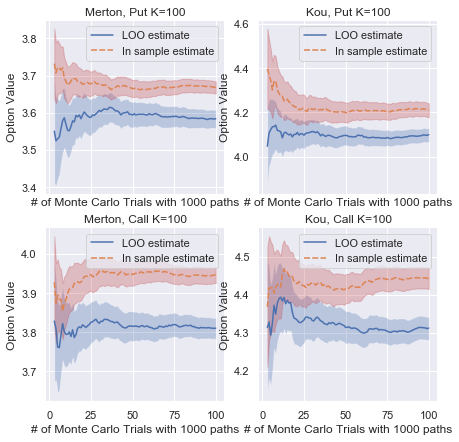

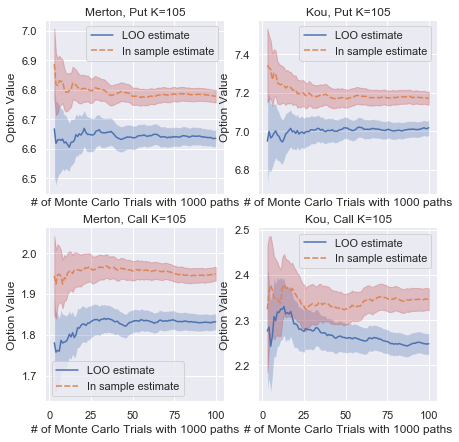

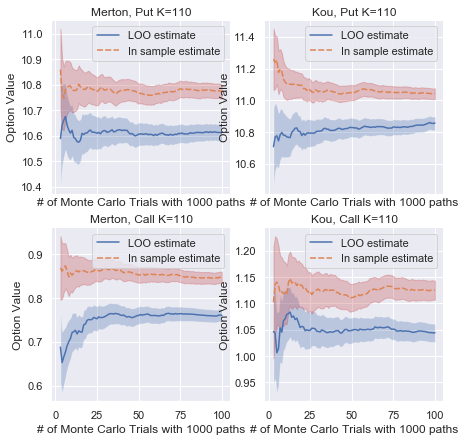

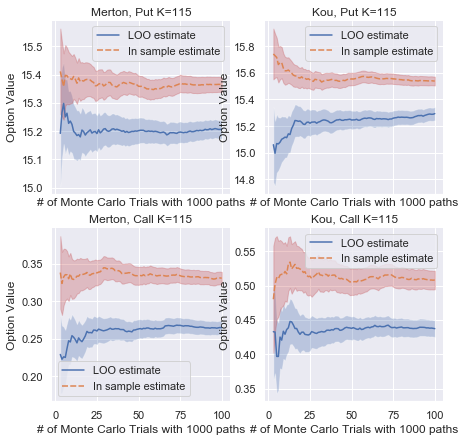

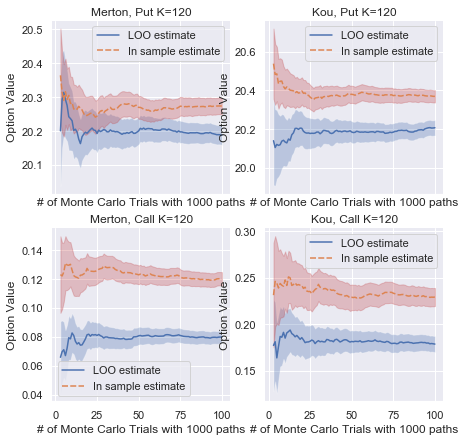

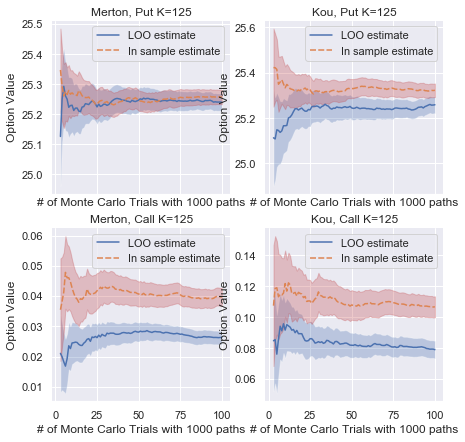

In [124]:
# Generating Graphs Comparing LOOMC/ISLSMC performance for different 
# models/strike prices for put and call

for i in range(11):
    np.random.seed(2020)
    k = 75+5*i
    kwargs1 = {'alpha':0.03, 'delta':0, 'sigma':0.3, 'alpha_j':-0.02,
               'sigma_j':0.05,'lambda_':5,'t':1/12, 's':100}

    kwargs2 = {'alpha':0.03, 'delta':0, 'sigma':0.3, 'lambda_':5, 
               'p':0.4, 'eta1':20, 'eta2':10, 't':1/12, 's':100}

    sim_merton_loo_put = [lhs_option_value_american_merton(
        k,0.03,npath=1000,call=False,**kwargs1) for i in range(100)]
    sim_merton_lsm_put = [lhs_option_value_american_merton_lsm(
        k,0.03,npath=1000,call=False,**kwargs1) for i in range(100)]
    
    means_merton_loo_put = np.array([np.mean(sim_merton_loo_put[:i]) for i in range(1,101)])
    sd_merton_loo_put = np.array([np.std(sim_merton_loo_put)/np.sqrt(i) for i in range(1,101)])
    means_merton_lsm_put = np.array([np.mean(sim_merton_lsm_put[:i]) for i in range(1,101)])
    sd_merton_lsm_put = np.array([np.std(sim_merton_lsm_put)/np.sqrt(i) for i in range(1,101)])
    upper_merton_loo_put = means_merton_loo_put + 2*sd_merton_loo_put
    lower_merton_loo_put = means_merton_loo_put -2*sd_merton_loo_put
    upper_merton_lsm_put = means_merton_lsm_put + 2*sd_merton_lsm_put
    lower_merton_lsm_put = means_merton_lsm_put - 2*sd_merton_lsm_put
    
    x_cord = [i for i in range(3,101)]


    data1 = pd.DataFrame({'LOO estimate':means_merton_loo_put,'In sample estimate':means_merton_lsm_put})
    #data index and #of MC trials difference of 1
    data1.index += 1

    sim_kou_loo_put = [lhs_option_value_american_kou(
        k,0.03,npath=1000,call=False,**kwargs2) for i in range(100)]
    sim_kou_lsm_put = [lhs_option_value_american_kou_lsm(
        k,0.03,call=False,npath=1000,**kwargs2) for i in range(100)]
     
    means_kou_loo_put = np.array([np.mean(sim_kou_loo_put[:i]) for i in range(1,101)])
    sd_kou_loo_put = np.array([np.std(sim_kou_loo_put)/np.sqrt(i) for i in range(1,101)])
    means_kou_lsm_put = np.array([np.mean(sim_kou_lsm_put[:i]) for i in range(1,101)])
    sd_kou_lsm_put = np.array([np.std(sim_kou_lsm_put)/np.sqrt(i) for i in range(1,101)])
    upper_kou_loo_put = means_kou_loo_put + 2*sd_kou_loo_put
    lower_kou_loo_put = means_kou_loo_put -2*sd_kou_loo_put
    upper_kou_lsm_put = means_kou_lsm_put + 2*sd_kou_lsm_put
    lower_kou_lsm_put = means_kou_lsm_put - 2*sd_kou_lsm_put
    
    data2 = pd.DataFrame({'LOO estimate':means_kou_loo_put,'In sample estimate':means_kou_lsm_put})
    data2.index += 1
  
    ##for call options
    sim_merton_loo_call = [lhs_option_value_american_merton(
        k,0.03,npath=1000,**kwargs1) for i in range(100)]
    sim_merton_lsm_call = [lhs_option_value_american_merton_lsm(
        k,0.03,npath=1000,**kwargs1) for i in range(100)]
    
    means_merton_loo_call = np.array([np.mean(sim_merton_loo_call[:i]) for i in range(1,101)])
    sd_merton_loo_call = np.array([np.std(sim_merton_loo_call)/np.sqrt(i) for i in range(1,101)])
    means_merton_lsm_call = np.array([np.mean(sim_merton_lsm_call[:i]) for i in range(1,101)])
    sd_merton_lsm_call = np.array([np.std(sim_merton_lsm_call)/np.sqrt(i) for i in range(1,101)])
    upper_merton_loo_call = means_merton_loo_call + 2*sd_merton_loo_call
    lower_merton_loo_call = means_merton_loo_call - 2*sd_merton_loo_call
    upper_merton_lsm_call = means_merton_lsm_call + 2*sd_merton_lsm_call
    lower_merton_lsm_call = means_merton_lsm_call - 2*sd_merton_lsm_call
    
    data3 = pd.DataFrame({'LOO estimate':means_merton_loo_call,'In sample estimate':means_merton_lsm_call})
    data3.index += 1    

    sim_kou_loo_call = [lhs_option_value_american_kou(
        k,0.03,npath=1000,**kwargs2) for i in range(100)]
    sim_kou_lsm_call = [lhs_option_value_american_kou_lsm(
        k,0.03,npath=1000,**kwargs2) for i in range(100)]
     
    means_kou_loo_call = np.array([np.mean(sim_kou_loo_call[:i]) for i in range(1,101)])
    sd_kou_loo_call = np.array([np.std(sim_kou_loo_call)/np.sqrt(i) for i in range(1,101)])
    means_kou_lsm_call = np.array([np.mean(sim_kou_lsm_call[:i]) for i in range(1,101)])
    sd_kou_lsm_call = np.array([np.std(sim_kou_lsm_call)/np.sqrt(i) for i in range(1,101)])
    upper_kou_loo_call = means_kou_loo_call + 2*sd_kou_loo_call
    lower_kou_loo_call = means_kou_loo_call - 2*sd_kou_loo_call
    upper_kou_lsm_call = means_kou_lsm_call + 2*sd_kou_lsm_call
    lower_kou_lsm_call = means_kou_lsm_call - 2*sd_kou_lsm_call
    
    data4 = pd.DataFrame({'LOO estimate':means_kou_loo_call,'In sample estimate':means_kou_lsm_call})
    data4.index += 1
    
    # Generating lineplots
    f, axes = plt.subplots(2, 2, figsize=(7, 7), sharex=True)
    sns.despine(left=True)
    sns.set(style='darkgrid')
    sns.lineplot(data=data1.iloc[2:,],ax=axes[0,0])
    axes[0,0].fill_between(x_cord,lower_merton_loo_put[2:],upper_merton_loo_put[2:],alpha=.3)
    axes[0,0].fill_between(x_cord,lower_merton_lsm_put[2:],upper_merton_lsm_put[2:],alpha=.3,color='r')   
    axes[0,0].set_title('Merton, Put K={}'.format(k))
    
    sns.lineplot(data=data2.iloc[2:,],ax=axes[0,1])
    axes[0,1].fill_between(x_cord,lower_kou_loo_put[2:],upper_kou_loo_put[2:],alpha=.3)
    axes[0,1].fill_between(x_cord,lower_kou_lsm_put[2:],upper_kou_lsm_put[2:],alpha=.3,color='r')
    axes[0,1].set_title('Kou, Put K={}'.format(k))
   
    sns.lineplot(data=data3.iloc[2:,],ax=axes[1,0])
    axes[1,0].fill_between(x_cord,lower_merton_loo_call[2:],upper_merton_loo_call[2:],alpha=.3)
    axes[1,0].fill_between(x_cord,lower_merton_lsm_call[2:],upper_merton_lsm_call[2:],alpha=.3,color='r')    
    axes[1,0].set_title('Merton, Call K={}'.format(k))

    sns.lineplot(data=data4.iloc[2:,],ax=axes[1,1])
    axes[1,1].fill_between(x_cord,lower_kou_loo_call[2:],upper_kou_loo_call[2:],alpha=.3)
    axes[1,1].fill_between(x_cord,lower_kou_lsm_call[2:],upper_kou_lsm_call[2:],alpha=.3,color='r')    
    axes[1,1].set_title('Kou, Call K={}'.format(k))

    for ax in axes.flat:
        ax.set(xlabel = '# of Monte Carlo Trials with 1000 paths', ylabel="Option Value")

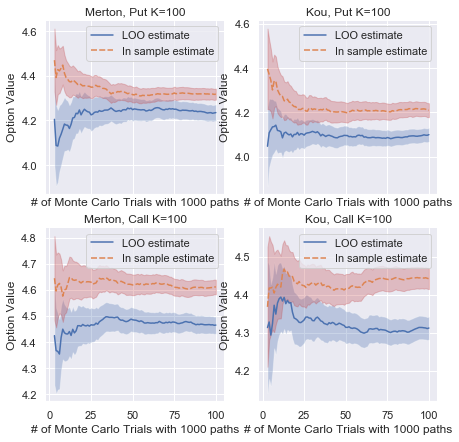

In [125]:
# control the overall expeted jump magnitude and return variance to be the same level 
# for Merton's and Kou's, what's the graph like

for i in range(1):
    np.random.seed(2020)
    k = 100+5*i
    kwargs1 = {'alpha':0.03, 'delta':0, 'sigma':0.3, 'alpha_j':-0.04,
               'sigma_j':0.11,'lambda_':5,'t':1/12, 's':100}

    kwargs2 = {'alpha':0.03, 'delta':0, 'sigma':0.3, 'lambda_':5, 
               'p':0.4, 'eta1':20, 'eta2':10, 't':1/12, 's':100}

    sim_merton_loo_put = [lhs_option_value_american_merton(
        k,0.03,npath=1000,call=False,**kwargs1) for i in range(100)]
    sim_merton_lsm_put = [lhs_option_value_american_merton_lsm(
        k,0.03,npath=1000,call=False,**kwargs1) for i in range(100)]
    
    means_merton_loo_put = np.array([np.mean(sim_merton_loo_put[:i]) for i in range(1,101)])
    sd_merton_loo_put = np.array([np.std(sim_merton_loo_put)/np.sqrt(i) for i in range(1,101)])
    means_merton_lsm_put = np.array([np.mean(sim_merton_lsm_put[:i]) for i in range(1,101)])
    sd_merton_lsm_put = np.array([np.std(sim_merton_lsm_put)/np.sqrt(i) for i in range(1,101)])
    upper_merton_loo_put = means_merton_loo_put + 2*sd_merton_loo_put
    lower_merton_loo_put = means_merton_loo_put -2*sd_merton_loo_put
    upper_merton_lsm_put = means_merton_lsm_put + 2*sd_merton_lsm_put
    lower_merton_lsm_put = means_merton_lsm_put - 2*sd_merton_lsm_put
    
    x_cord = [i for i in range(3,101)]


    data1 = pd.DataFrame({'LOO estimate':means_merton_loo_put,'In sample estimate':means_merton_lsm_put})
    #data index and #of MC trials difference of 1
    data1.index += 1

    sim_kou_loo_put = [lhs_option_value_american_kou(
        k,0.03,npath=1000,call=False,**kwargs2) for i in range(100)]
    sim_kou_lsm_put = [lhs_option_value_american_kou_lsm(
        k,0.03,call=False,npath=1000,**kwargs2) for i in range(100)]
     
    means_kou_loo_put = np.array([np.mean(sim_kou_loo_put[:i]) for i in range(1,101)])
    sd_kou_loo_put = np.array([np.std(sim_kou_loo_put)/np.sqrt(i) for i in range(1,101)])
    means_kou_lsm_put = np.array([np.mean(sim_kou_lsm_put[:i]) for i in range(1,101)])
    sd_kou_lsm_put = np.array([np.std(sim_kou_lsm_put)/np.sqrt(i) for i in range(1,101)])
    upper_kou_loo_put = means_kou_loo_put + 2*sd_kou_loo_put
    lower_kou_loo_put = means_kou_loo_put -2*sd_kou_loo_put
    upper_kou_lsm_put = means_kou_lsm_put + 2*sd_kou_lsm_put
    lower_kou_lsm_put = means_kou_lsm_put - 2*sd_kou_lsm_put
    
    data2 = pd.DataFrame({'LOO estimate':means_kou_loo_put,'In sample estimate':means_kou_lsm_put})
    data2.index += 1
  
    ##for call options
    sim_merton_loo_call = [lhs_option_value_american_merton(
        k,0.03,npath=1000,**kwargs1) for i in range(100)]
    sim_merton_lsm_call = [lhs_option_value_american_merton_lsm(
        k,0.03,npath=1000,**kwargs1) for i in range(100)]
    
    means_merton_loo_call = np.array([np.mean(sim_merton_loo_call[:i]) for i in range(1,101)])
    sd_merton_loo_call = np.array([np.std(sim_merton_loo_call)/np.sqrt(i) for i in range(1,101)])
    means_merton_lsm_call = np.array([np.mean(sim_merton_lsm_call[:i]) for i in range(1,101)])
    sd_merton_lsm_call = np.array([np.std(sim_merton_lsm_call)/np.sqrt(i) for i in range(1,101)])
    upper_merton_loo_call = means_merton_loo_call + 2*sd_merton_loo_call
    lower_merton_loo_call = means_merton_loo_call - 2*sd_merton_loo_call
    upper_merton_lsm_call = means_merton_lsm_call + 2*sd_merton_lsm_call
    lower_merton_lsm_call = means_merton_lsm_call - 2*sd_merton_lsm_call
    
    data3 = pd.DataFrame({'LOO estimate':means_merton_loo_call,'In sample estimate':means_merton_lsm_call})
    data3.index += 1    

    sim_kou_loo_call = [lhs_option_value_american_kou(
        k,0.03,npath=1000,**kwargs2) for i in range(100)]
    sim_kou_lsm_call = [lhs_option_value_american_kou_lsm(
        k,0.03,npath=1000,**kwargs2) for i in range(100)]
     
    means_kou_loo_call = np.array([np.mean(sim_kou_loo_call[:i]) for i in range(1,101)])
    sd_kou_loo_call = np.array([np.std(sim_kou_loo_call)/np.sqrt(i) for i in range(1,101)])
    means_kou_lsm_call = np.array([np.mean(sim_kou_lsm_call[:i]) for i in range(1,101)])
    sd_kou_lsm_call = np.array([np.std(sim_kou_lsm_call)/np.sqrt(i) for i in range(1,101)])
    upper_kou_loo_call = means_kou_loo_call + 2*sd_kou_loo_call
    lower_kou_loo_call = means_kou_loo_call - 2*sd_kou_loo_call
    upper_kou_lsm_call = means_kou_lsm_call + 2*sd_kou_lsm_call
    lower_kou_lsm_call = means_kou_lsm_call - 2*sd_kou_lsm_call
    
    data4 = pd.DataFrame({'LOO estimate':means_kou_loo_call,'In sample estimate':means_kou_lsm_call})
    data4.index += 1
    
    # Generating lineplots
    f, axes = plt.subplots(2, 2, figsize=(7, 7), sharex=True)
    sns.despine(left=True)
    sns.set(style='darkgrid')
    sns.lineplot(data=data1.iloc[2:,],ax=axes[0,0])
    axes[0,0].fill_between(x_cord,lower_merton_loo_put[2:],upper_merton_loo_put[2:],alpha=.3)
    axes[0,0].fill_between(x_cord,lower_merton_lsm_put[2:],upper_merton_lsm_put[2:],alpha=.3,color='r')   
    axes[0,0].set_title('Merton, Put K={}'.format(k))
    
    sns.lineplot(data=data2.iloc[2:,],ax=axes[0,1])
    axes[0,1].fill_between(x_cord,lower_kou_loo_put[2:],upper_kou_loo_put[2:],alpha=.3)
    axes[0,1].fill_between(x_cord,lower_kou_lsm_put[2:],upper_kou_lsm_put[2:],alpha=.3,color='r')
    axes[0,1].set_title('Kou, Put K={}'.format(k))
   
    sns.lineplot(data=data3.iloc[2:,],ax=axes[1,0])
    axes[1,0].fill_between(x_cord,lower_merton_loo_call[2:],upper_merton_loo_call[2:],alpha=.3)
    axes[1,0].fill_between(x_cord,lower_merton_lsm_call[2:],upper_merton_lsm_call[2:],alpha=.3,color='r')    
    axes[1,0].set_title('Merton, Call K={}'.format(k))

    sns.lineplot(data=data4.iloc[2:,],ax=axes[1,1])
    axes[1,1].fill_between(x_cord,lower_kou_loo_call[2:],upper_kou_loo_call[2:],alpha=.3)
    axes[1,1].fill_between(x_cord,lower_kou_lsm_call[2:],upper_kou_lsm_call[2:],alpha=.3,color='r')    
    axes[1,1].set_title('Kou, Call K={}'.format(k))

    for ax in axes.flat:
        ax.set(xlabel = '# of Monte Carlo Trials with 1000 paths', ylabel="Option Value")


# Empirical study on American options



## UAL

In [596]:
data = yf.download('UAL', end="2020-05-01",progressive=False)
ual=np.array(data['Close'])
returns = np.log(ual[1:]/ual[:(len(ual)-1)])
print(np.std(returns))

[*********************100%***********************]  1 of 1 completed
0.04202111696976367


[Text(0, 0.5, 'returns'), Text(0.5, 0, 'time')]

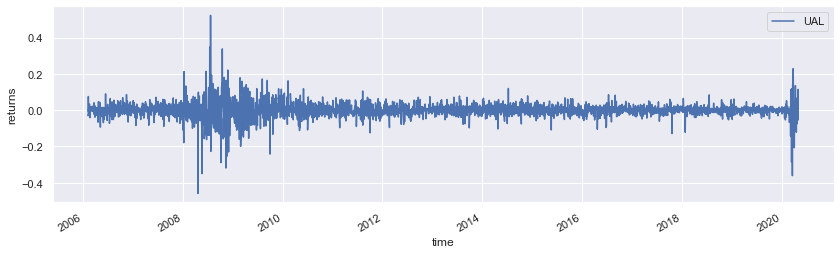

In [515]:
df = pd.DataFrame({'date':data.index[1:],'returns':returns})
df = df.set_index('date')

fig, ax = plt.subplots(figsize=(14,4))
df.plot(y='returns',label='UAL',ax=ax)
ax.set(xlabel='time',ylabel='returns')

In [354]:
# download historical stock price data
data = yf.download('UAL', start="2018-01-01", end="2020-01-11",progressive=False)
ual=np.array(data['Close'])
returns = np.log(ual[1:]/ual[:(len(ual)-1)])
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,67.900002,69.010002,67.379997,68.940002,68.940002,3390600
2018-01-03,68.940002,69.370003,67.820000,68.489998,68.489998,4590900
2018-01-04,68.690002,69.370003,67.639999,69.260002,69.260002,3922900
2018-01-05,69.400002,69.400002,68.769997,69.360001,69.360001,2675900
2018-01-08,69.370003,69.370003,68.010002,68.510002,68.510002,4277900
...,...,...,...,...,...,...
2020-01-06,86.720001,88.070000,86.650002,87.699997,87.699997,2652700
2020-01-07,87.410004,88.160004,86.739998,86.769997,86.769997,2581300
2020-01-08,86.900002,88.449997,86.300003,87.300003,87.300003,4152500


## Scrape option historical data

In [141]:
## A method to scrape option historical data from Tradier's API


class Tradier:
    def __init__(self, auth: str, storage_path="C:\\Users\\kywan\\OneDrive\\Desktop\\lsmoption"):
        self.storage_path = storage_path
        self.connection = http.client.HTTPSConnection(
            "sandbox.tradier.com", 443, timeout=30)
        self.headers = headers = {"Accept": "application/json",
                                  "Authorization": "Bearer {}".format(auth)}

    def request(self, endpoint: str):
        self.connection.request("GET", endpoint, None, self.headers)
        try:
            response = self.connection.getresponse()
            content = response.read()
            if int(str(response.status)) == 200:
                return json.loads(bytes.decode(content))
            return None
        except http.HTTPException as e:
            return e

    def options(self, symbol: str):
        return Options(self, symbol)

    def historical_data(self, symbol: str):
        endpoint = "/v1/markets/history?symbol={}".format(symbol)
        return self.request(endpoint)

    def load_data(self, symbol: str) -> pd.DataFrame:
        path = self.storage_path + "{}.csv".format(symbol)
        if os.path.exists(path):
            df = pd.read_csv(path)
            df = df.set_index(pd.DatetimeIndex(df["date"]))
            df = df.loc[:, ~df.columns.str.contains('date')]
            df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
            return df
        else:
            try:
                df = pd.DataFrame(self.historical_data(
                    symbol).get("history", {}).get("day", []))
                df = df.set_index(pd.DatetimeIndex(df["date"]))
                df = df.loc[:, ~df.columns.str.contains('date')]
                df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
                df.to_csv(path)
                return df
            except Exception as e:
                print(e)
                return None


def third_fridays(d, n):
    """Given a date, calculates n next third fridays
    https://stackoverflow.com/questions/28680896/how-can-i-get-the-3rd-friday-of-a-month-in-python/28681097"""

    def next_third_friday(d):
        """ Given a third friday find next third friday"""
        d += timedelta(weeks=4)
        return d if d.day >= 15 else d + timedelta(weeks=1)

    # Find closest friday to 15th of month
    s = date(d.year, d.month, 15)
    result = [s + timedelta(days=(calendar.FRIDAY - s.weekday()) % 7)]

    # This month's third friday passed. Find next.
    if result[0] < d:
        result[0] = next_third_friday(result[0])

    for i in range(n - 1):
        result.append(next_third_friday(result[-1]))

    return result


class Options:
    def __init__(self, tradier: Tradier, symbol: str):
        self.api = tradier
        self.symbol = symbol
        self.cache = {}

    def call(self, expiration: date, strike: int) -> pd.DataFrame:
        chain = "{symbol}{y}{m:02d}{d:02d}C{strike:05d}000".format(symbol=self.symbol, y=str(
            expiration.year)[2:], m=expiration.month, d=expiration.day, strike=strike)
        if chain in self.cache:
            return self.cache[chain]
        else:
            df = self.api.load_data(chain)
            self.cache[chain] = df
            return df

    def put(self, expiration: date, strike: int) -> pd.DataFrame:
        chain = "{symbol}{y}{m:02d}{d:02d}P{strike:05d}000".format(symbol=self.symbol, y=str(
            expiration.year)[2:], m=expiration.month, d=expiration.day, strike=strike)
        if chain in self.cache:
            return self.cache[chain]
        else:
            df = self.api.load_data(chain)
            self.cache[chain] = df
            return df

    def initialize_repository(self):
        ''' 
        Download all of the historical price data for all monthly expirations within a 10%
        price range of the underlying for that month. This can be manually changed in the code 
        below. By default, this downloads data from 2018 only. Beyond that is an exercise for the reader
        '''

        # historical price data for the underlying, which we will merge in
        data = self.api.load_data(self.symbol)

        # calculate monthly high and low for the underlying
        monthly_range = {}
        for m in range(1, 13):
            try:
                x = data[date(2018, m, 1):date(2018, m + 1, 1)]
                monthly_range[m] = dict(low=min(x['low']), high=max(x['high']))
            except:
                # If we don't have data for this month, just extrapolate from the previous month
                monthly_range[m] = dict(
                    low=monthly_range[m - 1]['low'], high=monthly_range[m - 1]['high'])

        for m, k in monthly_range.items():
            expiration = third_fridays(date(2018, m, 1), 1)[0]
            # Get all strikes that are 10% below the monthly low and 10% above the monthly high
            strikes = [x for x in range(int(k['low'] * .9), int(k['high'] * 1.1))]
            # Download and save all of the option chains
            for s in strikes:
                self.call(expiration, s)
                self.put(expiration, s)


In [138]:
d = date(2020,1,1)

third_fridays(d,20)

[datetime.date(2020, 1, 17),
 datetime.date(2020, 2, 21),
 datetime.date(2020, 3, 20),
 datetime.date(2020, 4, 17),
 datetime.date(2020, 5, 15),
 datetime.date(2020, 6, 19),
 datetime.date(2020, 7, 17),
 datetime.date(2020, 8, 21),
 datetime.date(2020, 9, 18),
 datetime.date(2020, 10, 16),
 datetime.date(2020, 11, 20),
 datetime.date(2020, 12, 18),
 datetime.date(2021, 1, 15),
 datetime.date(2021, 2, 19),
 datetime.date(2021, 3, 19),
 datetime.date(2021, 4, 16),
 datetime.date(2021, 5, 21),
 datetime.date(2021, 6, 18),
 datetime.date(2021, 7, 16),
 datetime.date(2021, 8, 20)]

In [422]:
api = Tradier("0PZGXwG84qeJdfoeiDDgO3Ab3V2k")
UAL200619P00090000 = api.options("UAL").put(dt.date(2020, 6, 19), 90)

In [424]:
print(UAL200619P00090000)

             open   high    low  close  volume
date                                          
2020-01-02   5.85   5.85   5.85   5.85      20
2020-01-03   7.65   7.65   7.60   7.60      22
2020-01-09   7.00   7.07   6.96   7.04     590
2020-01-10   7.12   7.17   6.99   7.14     688
2020-01-16   6.10   6.10   6.10   6.10      30
2020-01-17   6.05   6.05   6.05   6.05     430
2020-01-22   7.90   7.90   7.90   7.90       3
2020-01-24  10.75  10.75  10.75  10.75       1
2020-01-27  13.70  13.71  13.30  13.30     102
2020-02-05  10.75  10.75  10.40  10.40       2
2020-02-06  11.90  11.90  11.90  11.90       2
2020-02-07  12.41  12.41  12.40  12.41      15
2020-02-14  11.51  11.85  11.51  11.85     102
2020-02-21  13.40  13.60  13.40  13.60       7
2020-02-25  18.10  18.10  18.10  18.10      50
2020-03-03  31.19  31.19  31.19  31.19       4
2020-03-13  52.92  52.92  52.92  52.92      33
2020-03-18  69.50  69.50  69.50  69.50       7
2020-03-25  55.00  55.00  52.80  52.80       5
2020-04-02  6

In [144]:
#get trading days

from pandas.tseries.holiday import (AbstractHolidayCalendar, Holiday, nearest_workday,
USMartinLutherKingJr, USPresidentsDay, GoodFriday, USMemorialDay,
USLaborDay, USThanksgivingDay)


class USTradingCalendar(AbstractHolidayCalendar):
    rules = [
        Holiday('NewYearsDay', month=1, day=1, observance=nearest_workday),
        USMartinLutherKingJr,
        USPresidentsDay,
        GoodFriday,
        USMemorialDay,
        Holiday('USIndependenceDay', month=7, day=4, observance=nearest_workday),
        USLaborDay,
        USThanksgivingDay,
        Holiday('Christmas', month=12, day=25, observance=nearest_workday)
    ]


def get_trading_close_holidays(year):
    inst = USTradingCalendar()

    return inst.holidays(dt.datetime(year-1, 12, 31), dt.datetime(year, 12, 31))

In [466]:
# download historical stock price data
data = yf.download('UAL', start="2018-01-01", end="2020-01-11",progressive=False)
ual=np.array(data['Close'])
returns = np.log(ual[1:]/ual[:(len(ual)-1)])

[*********************100%***********************]  1 of 1 completed


In [467]:
# trading days till expiration third friday
t = len(pd.bdate_range(start='2020-1-10',end='2020-6-19',freq='C',
               holidays=get_trading_close_holidays(2020),closed='right'))/252

In [468]:
# estimate annual return and volitility for UAL
## GBM Strtified
vol = np.sqrt(np.var(returns)*252)
kwargs = {'alpha':0.02, 'delta':0, 'sigma': vol, 't':t, 's':ual[-1]}

np.random.seed(2020)
gbm = stratified_option_value_american(90,0.02,call=False,npath=1000,**kwargs)
print("UAL200619P00090000 on 2020-01-10 GBM: {}".format(gbm))

UAL200619P00090000 on 2020-01-10 GBM: 7.7206062613588875


In [469]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
scaled_returns = scaler.fit_transform(returns.reshape(-1,1))
return_jumps = returns[(abs(scaled_returns)>3)[:,0]]
np.sort(return_jumps)

array([-0.12149323, -0.05297493,  0.05746732,  0.05780344,  0.0616094 ,
        0.06501298,  0.08420745])

In [470]:
#LOO Merton
#estimate sigma_j using assumed log return's normality
#sigma_j = np.std(return_jumps)
sigma_j = (np.sort(return_jumps)[len(return_jumps)-1] - np.sort(return_jumps)[0])/6
#estimate merton's parameters
lambda_ = (sum(abs(scaled_returns)>3)/len(returns)*252)[0]

alpha_j = np.mean(return_jumps)
sigma = np.sqrt(np.var(returns)*252-lambda_*(sigma_j**2+alpha_j**2))
kwargs = {'alpha':0.02,'delta':0,'lambda_':lambda_, 'sigma':sigma, 'alpha_j': alpha_j, 
          'sigma_j':sigma_j,'t':t,'s':ual[-1]}

np.random.seed(2020)
loomerton = lhs_option_value_american_merton(90,0.02,npath=1000,call=False,**kwargs)

#In sample Merton
insmerton = lhs_option_value_american_merton_lsm(90,0.02,npath=1000,call=False,**kwargs)

print("UAL200619P00090000 on 2020-01-10 LOO Merton: {}".format(loomerton))
print("UAL200619P00090000 on 2020-01-10 In sample Merton: {}".format(insmerton))
print(kwargs)

UAL200619P00090000 on 2020-01-10 LOO Merton: 7.313745402903625
UAL200619P00090000 on 2020-01-10 In sample Merton: 7.676555181335066
{'alpha': 0.02, 'delta': 0, 'lambda_': 3.4656188605108054, 'sigma': 0.2666659321286203, 'alpha_j': 0.021661776324424755, 'sigma_j': 0.03428344626424421, 't': 0.44047619047619047, 's': 87.30999755859375}


In [417]:
#LOO Kou
np.random.seed(2020)

lambda_ = (sum(abs(scaled_returns)>3)/len(returns)*252)[0]
p = sum(return_jumps>0)/len(return_jumps)
q = 1-p
# solve nonlinear system to get eta1, eta2 estimation
def equations(u):
    x,y = u
    return (p/x-q/y-np.mean(return_jumps),(1-q**2)/x**2+(1-p**2)/y**2 + 2*
            p*q/(x*y)-np.var(return_jumps))
eta1, eta2 = fsolve(equations, (5,10))

# sigma correction
sigma = np.sqrt(np.var(returns)*252-2*lambda_*(p/eta1**2+(1-p)/eta2**2))
kwargs = {'alpha':0.02, 'delta':0, 'lambda_':lambda_, 'sigma':sigma,
          'p':p, 'eta1':eta1, 'eta2':eta2, 't':t, 's':ual[-1]}

np.random.seed(2020)
lookou = lhs_option_value_american_kou(90,0.02,npath=1000,call=False,**kwargs)

#In sample Kou
inskou = lhs_option_value_american_kou_lsm(90,0.02,npath=1000,call=False,**kwargs)

print("UAL200619P00090000 on 2020-01-10 LOO Kou: {}".format(lookou))
print("UAL200619P00090000 on 2020-01-10 In sample Kou: {}".format(inskou))
print(kwargs)

UAL200619P00090000 on 2020-01-10 LOO Kou: 7.446496902445191
UAL200619P00090000 on 2020-01-10 In sample Kou: 7.532507453939313
{'alpha': 0.02, 'delta': 0, 'lambda_': 3.4656188605108054, 'sigma': 0.239460614243078, 'p': 0.7142857142857143, 'eta1': 19.137499928069406, 'eta2': 18.242397474460173, 't': 0.44047619047619047, 's': 87.30999755859375}


In [471]:
# For every trading day with volume>=10, calculate the MC estimate and compare with close price
data = yf.download('UAL', start="2018-01-01",progressive=False)

k=90
r=0.02
gbm = []
loomerton = []
insmerton = []
lookou = []
inskou = []
# leave out days with volume<10
ualsubset = UAL200619P00090000.loc[UAL200619P00090000['volume']>=10]

for date in ualsubset.index:
    #get the end date
    date = dt.date(date.year,date.month,date.day)
    end = data.index.searchsorted(dt.datetime(date.year,date.month,date.day))
    ual=np.array(data.iloc[:(end+1)]['Close'])
    returns = np.log(ual[1:]/ual[:(len(ual)-1)])
    #print(returns)
    #jumps
    scaler = preprocessing.StandardScaler()
    scaled_returns = scaler.fit_transform(returns.reshape(-1,1))
    return_jumps = returns[(abs(scaled_returns)>3)[:,0]]
    
    if len(return_jumps)==0:
        return_jumps = np.array([0])
    
    t = len(pd.bdate_range(start=date,end='2020-6-19',freq='C',
               holidays=get_trading_close_holidays(2020),closed='right'))/252
    
    np.random.seed(2020)
    ## GBM Stratified
    vol = np.sqrt(np.var(returns)*252)
    kwargs1 = {'alpha':r, 'delta':0, 'sigma': vol, 't':t, 's':ual[-1]}
    gbm.append(stratified_option_value_american(k,r,call=False,npath=1000,**kwargs1))   
    
    ## Merton
    sigma_j = (np.sort(return_jumps)[len(return_jumps)-1] - np.sort(return_jumps)[0])/6
    alpha_j = np.mean(return_jumps)
    sigma = np.sqrt(max(0,np.var(returns)*252-lambda_*(sigma_j**2+alpha_j**2)))
    lambda_ = (sum(abs(scaled_returns)>3)/len(returns)*252)[0]
    kwargs2 = {'alpha':r,'delta':0,'lambda_':lambda_, 'sigma':sigma, 'alpha_j': alpha_j, 
              'sigma_j':sigma_j,'t':t,'s':ual[-1]}
    
    loomerton.append(lhs_option_value_american_merton(k,r,npath=1000,call=False,**kwargs2))
    insmerton.append(lhs_option_value_american_merton_lsm(k,r,npath=1000,call=False,**kwargs2))

    ## Kou
    p = sum(return_jumps>0)/max(len(return_jumps),1)
    q = 1-p
    # solve nonlinear system to get eta1, eta2 estimation
    def equations(u):
        x,y = u
        return (p/x-q/y-np.mean(return_jumps),(1-q**2)/x**2+(1-p**2)/y**2 + 2*
                p*q/(x*y)-np.var(return_jumps))
    
    eta1, eta2 = fsolve(equations, (5,10))
    #print([eta1,eta2])

    ### sigma correction
    sigma = np.sqrt(max(0,np.var(returns)*252-2*lambda_*(p/eta1**2+(1-p)/eta2**2)))
    
    kwargs3 = {'alpha':r, 'delta':0, 'lambda_':lambda_, 'sigma':sigma,
               'p':p, 'eta1':eta1, 'eta2':eta2, 't':t, 's':ual[-1]}

    lookou.append(lhs_option_value_american_kou(k,r,npath=1000,call=False,**kwargs3))
    inskou.append(lhs_option_value_american_kou_lsm(k,r,npath=1000,call=False,**kwargs3))


[*********************100%***********************]  1 of 1 completed


In [472]:
#RMSE
print("RMSE for GBM: {}".format(
    np.sqrt(np.mean((gbm - ualsubset['close'])**2))))
print("RMSE for LOO Merton: {}".format(
    np.sqrt(np.mean((loomerton - ualsubset['close'])**2))))
print("RMSE for In sample Merton: {}".format(
    np.sqrt(np.mean((insmerton - ualsubset['close'])**2))))
print("RMSE for LOO Kou: {}".format(
    np.sqrt(np.mean((lookou - ualsubset['close'])**2))))
print("RMSE for In sample Kou: {}".format(
    np.sqrt(np.mean((inskou - ualsubset['close'])**2))))


RMSE for GBM: 1.5065906034704852
RMSE for LOO Merton: 1.0671286972548164
RMSE for In sample Merton: 1.4168354394069993
RMSE for LOO Kou: 1.0060751570498199
RMSE for In sample Kou: 1.4775865162796695


In [473]:
result1 = {'Close':ualsubset['close'],'GBM':gbm,'LOOMerton':loomerton,
           'InsampleMerton':insmerton,'LOOKou':lookou,'InsampleKou':inskou}
pd.DataFrame(result1)

,Close,GBM,LOOMerton,InsampleMerton,LOOKou,InsampleKou
date,,,,,,
2020-01-02,5.85,6.887468,6.467313,6.663888,6.727082,6.558909
2020-01-03,7.60,7.621232,7.267359,7.414797,8.309904,7.681268
2020-01-09,7.04,7.458668,7.245688,7.435493,7.339052,7.539552
2020-01-10,7.14,7.720606,7.124135,7.894914,7.005008,7.744010
2020-01-16,6.10,6.523936,6.394887,6.523178,6.259629,6.407007
2020-01-17,6.05,6.128288,6.408129,6.388592,5.880857,6.299347
2020-01-27,13.30,14.154381,13.813868,14.072239,13.920675,13.702344
2020-02-07,12.41,12.547495,12.516690,12.079301,12.661785,12.414101
2020-02-14,11.85,12.269837,12.036328,12.167039,12.974348,12.474639


In [474]:
#MAPE
print("MAPE for GBM: {}".format(np.mean(abs(
    gbm-ualsubset['close'])/ualsubset['close'])))
print("MAPE for LOO Merton: {}".format(np.mean(abs(
    loomerton-ualsubset['close'])/ualsubset['close'])))
print("MAPE for In sample Merton: {}".format(np.mean(abs(
    insmerton-ualsubset['close'])/ualsubset['close'])))
print("MAPE for LOO Kou: {}".format(np.mean(abs(
    lookou-ualsubset['close'])/ualsubset['close'])))
print("MAPE for In sample Kou: {}".format(np.mean(abs(
    inskou-ualsubset['close'])/ualsubset['close'])))


MAPE for GBM: 0.0646574025067664
MAPE for LOO Merton: 0.04904945089389871
MAPE for In sample Merton: 0.0663530016179387
MAPE for LOO Kou: 0.06128177015933869
MAPE for In sample Kou: 0.05824292698736678


### Impact of Covid19

In [547]:
data = yf.download('UAL', start="2018-01-01", end="2020-04-03",progressive=False)
ual=np.array(data['Close'])
returns = np.log(ual[1:]/ual[:(len(ual)-1)])
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,67.900002,69.010002,67.379997,68.940002,68.940002,3390600
2018-01-03,68.940002,69.370003,67.820000,68.489998,68.489998,4590900
2018-01-04,68.690002,69.370003,67.639999,69.260002,69.260002,3922900
2018-01-05,69.400002,69.400002,68.769997,69.360001,69.360001,2675900
2018-01-08,69.370003,69.370003,68.010002,68.510002,68.510002,4277900
...,...,...,...,...,...,...
2020-03-27,35.020000,35.200001,32.029999,32.840000,32.840000,18379600
2020-03-30,30.690001,31.799999,28.000000,30.160000,30.160000,18386400
2020-03-31,31.309999,33.599998,30.580000,31.549999,31.549999,16568800


In [548]:
#put with K=30
api = Tradier("0PZGXwG84qeJdfoeiDDgO3Ab3V2k")
UAL200619P00030000 = api.options("UAL").put(dt.date(2020, 6, 19), 30)
ualsubset = UAL200619P00030000.loc[UAL200619P00030000['volume']>=10]
print(ualsubset)

             open   high    low  close  volume
date                                          
2020-03-04   1.25   1.32   1.20   1.22      55
2020-03-05   1.22   2.00   1.22   2.00     516
2020-03-06   2.50   3.20   2.06   3.15     199
2020-03-09   3.20   5.80   3.20   4.00     105
2020-03-10   3.75   4.20   3.40   3.55     286
2020-03-11   4.10   4.45   3.80   4.30      54
2020-03-12   5.14   6.94   5.14   6.94     179
2020-03-13   5.46   8.35   5.46   6.60     250
2020-03-16   8.52   9.00   6.90   7.56     219
2020-03-17   8.60   9.30   7.65   9.30      87
2020-03-18  10.60  15.47  10.45  14.35     594
2020-03-19  13.85  14.35  12.70  14.35      25
2020-03-20  13.45  13.45  10.03  12.20      21
2020-03-23  11.90  12.20  11.20  11.35      91
2020-03-24   9.50   9.50   7.58   8.15      52
2020-03-25   7.00   7.59   5.95   6.00     124
2020-03-26   5.35   6.13   5.25   6.13      68
2020-03-27   6.80   7.15   6.00   6.45     523
2020-03-30   7.60   7.60   5.85   6.61    1237
2020-03-31   

In [549]:
# trading days till expiration third friday
t = len(pd.bdate_range(start='2020-04-02',end='2020-6-19',freq='C',
               holidays=get_trading_close_holidays(2020),closed='right'))/252

In [550]:
##GBM

vol = np.sqrt(np.var(returns)*252)
kwargs = {'alpha':0.01, 'delta':0, 'sigma': vol, 't':t, 's':ual[-1]}
np.random.seed(2020)
gbm = stratified_option_value_american(30,0.01,call=False,npath=1000,**kwargs)
print("UAL200619P00030000 on 2020-04-02 GBM: {}".format(gbm))


UAL200619P00030000 on 2020-04-02 GBM: 7.189891163053623


In [554]:
np.random.seed(2020)
#return jumps
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
scaled_returns = scaler.fit_transform(returns.reshape(-1,1))
return_jumps = returns[(abs(scaled_returns)>3)[:,0]]

lambda_ = (sum(abs(scaled_returns)>3)/len(returns)*252)[0]
sigma_j = (np.sort(return_jumps)[len(return_jumps)-1] - np.sort(return_jumps)[0])/6
sigma = np.sqrt(np.var(returns)*252-lambda_*(sigma_j**2+alpha_j**2))
alpha_j = np.mean(return_jumps)
kwargs = {'alpha':0.01,'delta':0,'lambda_':lambda_, 'sigma':sigma, 'alpha_j': alpha_j, 
          'sigma_j':sigma_j,'t':t,'s':ual[-1]}

#LOO Merton
loomerton = lhs_option_value_american_merton(30,0.01,npath=1000,call=False,**kwargs)

#In sample Merton
insmerton = lhs_option_value_american_merton_lsm(30,0.01,npath=1000,call=False,**kwargs)

print("UAL200619P00030000 on 2020-04-02 LOO Merton: {}".format(loomerton))
print("UAL200619P00030000 on 2020-04-02 In sample Merton: {}".format(insmerton))


UAL200619P00030000 on 2020-04-02 LOO Merton: 7.113072401937921
UAL200619P00030000 on 2020-04-02 In sample Merton: 7.0787633662277685


In [555]:
#LOO Kou
np.random.seed(2020)

lambda_ = (sum(abs(scaled_returns)>3)/len(returns)*252)[0]
p = sum(return_jumps>0)/len(return_jumps)
q = 1-p
# solve nonlinear system to get eta1, eta2 estimation
def equations(u):
    x,y = u
    return (p/x-q/y-np.mean(return_jumps),(1-q**2)/x**2+(1-p**2)/y**2 + 2*
            p*q/(x*y)-np.var(return_jumps))
eta1, eta2 = fsolve(equations, (5,10))

# sigma correction
sigma = np.sqrt(np.var(returns)*252-2*lambda_*(p/eta1**2+(1-p)/eta2**2))
kwargs = {'alpha':0.01, 'delta':0, 'lambda_':lambda_, 'sigma':sigma,
          'p':p, 'eta1':eta1, 'eta2':eta2, 't':t, 's':ual[-1]}

np.random.seed(2020)
lookou = lhs_option_value_american_kou(30,0.01,npath=1000,call=False,**kwargs)

#In sample Kou
inskou = lhs_option_value_american_kou_lsm(30,0.01,npath=1000,call=False,**kwargs)

print("UAL200619P00030000 on 2020-04-02 LOO Kou: {}".format(lookou))
print("UAL200619P00030000 on 2020-04-02 In sample Kou: {}".format(inskou))
print(kwargs)

UAL200619P00030000 on 2020-04-02 LOO Kou: 6.809433864419236
UAL200619P00030000 on 2020-04-02 In sample Kou: 6.743608149852113
{'alpha': 0.01, 'delta': 0, 'lambda_': 5.787985865724382, 'sigma': 0.30188485395829084, 'p': 0.38461538461538464, 'eta1': 11.902661671993766, 'eta2': 6.425998929372812, 't': 0.21428571428571427, 's': 23.420000076293945}


[*********************100%***********************]  1 of 1 completed


[Text(0, 0.5, 'returns'), Text(0.5, 0, 'time')]

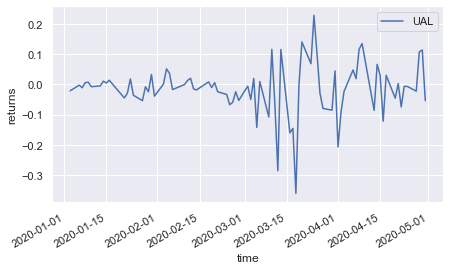

In [556]:
data = yf.download('UAL', start="2020-01-01", end="2020-05-01",progressive=False)
ual=np.array(data['Close'])
returns = np.log(ual[1:]/ual[:(len(ual)-1)])

df = pd.DataFrame({'date':data.index[1:],'returns':returns})
df = df.set_index('date')

fig, ax = plt.subplots(figsize=(7,4))
df.plot(y='returns',label='UAL',ax=ax)
ax.set(xlabel='time',ylabel='returns')

In [580]:
# change the horizon, only use data starting in January 2020 when the COVID19 news broke out
data = yf.download('UAL', start="2020-01-01", end="2020-04-03",progressive=False)
ual=np.array(data['Close'])
returns = np.log(ual[1:]/ual[:(len(ual)-1)])
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,89.570000,90.570000,89.110001,89.739998,89.739998,2769800
2020-01-03,86.800003,88.160004,86.260002,87.900002,87.900002,3562900
2020-01-06,86.720001,88.070000,86.650002,87.699997,87.699997,2652700
2020-01-07,87.410004,88.160004,86.739998,86.769997,86.769997,2581300
2020-01-08,86.900002,88.449997,86.300003,87.300003,87.300003,4152500
...,...,...,...,...,...,...
2020-03-27,35.020000,35.200001,32.029999,32.840000,32.840000,18379600
2020-03-30,30.690001,31.799999,28.000000,30.160000,30.160000,18386400
2020-03-31,31.309999,33.599998,30.580000,31.549999,31.549999,16568800


In [581]:
# estimate annual return and volitility for UAL
## GBM Strtified
vol = np.sqrt(np.var(returns)*252)
# trading days till expiration third friday
t = len(pd.bdate_range(start='2020-4-2',end='2020-6-19',freq='C',
               holidays=get_trading_close_holidays(2020),closed='right'))/252
kwargs = {'alpha':0.01, 'delta':0, 'sigma': vol, 't':t, 's':ual[-1]}

np.random.seed(2020)
gbm = stratified_option_value_american(30,0.01,call=False,npath=1000,**kwargs)
print("UAL200619P00030000 on 2020-04-02 GBM: {}".format(gbm))

UAL200619P00030000 on 2020-04-02 GBM: 10.637836607916027


In [582]:
#jumps
return_jumps = returns[abs(returns-np.mean(returns))>=0.12]
sorted_returnj = np.sort(return_jumps)
sorted_returnj

array([-0.36082911, -0.28565732, -0.20703001, -0.16037393, -0.14540232,
       -0.14214415,  0.10354064,  0.11598344,  0.11649967,  0.14090542,
        0.22884157])

In [583]:
sigma_j = (sorted_returnj[-1]-sorted_returnj[0])/6
alpha_j = np.mean(return_jumps)
sigma = np.sqrt(np.var(returns)*252-lambda_*(sigma_j**2+alpha_j**2))
lambda_ = (len(return_jumps))/len(returns)*252
kwargs = {'alpha':0.01,'delta':0,'lambda_':lambda_, 'sigma':sigma, 'alpha_j': alpha_j, 
          'sigma_j':sigma_j,'t':t,'s':ual[-1]}

np.random.seed(2020)
loomerton = lhs_option_value_american_merton(30,0.01,npath=1000,call=False,**kwargs)

#In sample Merton
insmerton = lhs_option_value_american_merton_lsm(30,0.01,npath=1000,call=False,**kwargs)

print("UAL200619P00030000 on 2020-04-02 LOO Merton: {}".format(loomerton))
print("UAL200619P00030000 on 2020-04-02 In sample Merton: {}".format(insmerton))

UAL200619P00030000 on 2020-04-02 LOO Merton: 9.936081843116456
UAL200619P00030000 on 2020-04-02 In sample Merton: 10.437137311059855


In [584]:
np.random.seed(2020)

lambda_ = (len(return_jumps))/len(returns)*252
p = sum(return_jumps>0)/len(return_jumps)
q = 1-p
# solve nonlinear system to get eta1, eta2 estimation
def equations(u):
    x,y = u
    return (p/x-q/y-np.mean(return_jumps),(1-q**2)/x**2+(1-p**2)/y**2 + 2*
            p*q/(x*y)-np.var(return_jumps))
eta1, eta2 = fsolve(equations, (5,10))

# sigma correction
sigma = np.sqrt(np.var(returns)*252-2*lambda_*(p/eta1**2+(1-p)/eta2**2))
kwargs = {'alpha':0.01, 'delta':0, 'lambda_':lambda_, 'sigma':sigma,
          'p':p, 'eta1':eta1, 'eta2':eta2, 't':t, 's':ual[-1]}

lookou = lhs_option_value_american_kou(30,0.01,npath=1000,call=False,**kwargs)

#In sample Kou
inskou = lhs_option_value_american_kou_lsm(30,0.01,npath=1000,call=False,**kwargs)

print("UAL200619P00030000 on 2020-04-02 LOO Kou: {}".format(lookou))
print("UAL200619P00030000 on 2020-04-02 In sample Kou: {}".format(inskou))
print(kwargs)

UAL200619P00030000 on 2020-04-02 LOO Kou: 9.63369560006945
UAL200619P00030000 on 2020-04-02 In sample Kou: 9.867300172755476
{'alpha': 0.01, 'delta': 0, 'lambda_': 44.0, 'sigma': 0.44680336285833755, 'p': 0.45454545454545453, 'eta1': 11.445696751053424, 'eta2': 5.811073243667949, 't': 0.21428571428571427, 's': 23.420000076293945}


In [585]:
ualsubset = UAL200619P00030000.loc[UAL200619P00030000['volume']>=100]
print(ualsubset)

             open   high    low  close  volume
date                                          
2020-03-05   1.22   2.00   1.22   2.00     516
2020-03-06   2.50   3.20   2.06   3.15     199
2020-03-09   3.20   5.80   3.20   4.00     105
2020-03-10   3.75   4.20   3.40   3.55     286
2020-03-12   5.14   6.94   5.14   6.94     179
2020-03-13   5.46   8.35   5.46   6.60     250
2020-03-16   8.52   9.00   6.90   7.56     219
2020-03-18  10.60  15.47  10.45  14.35     594
2020-03-25   7.00   7.59   5.95   6.00     124
2020-03-27   6.80   7.15   6.00   6.45     523
2020-03-30   7.60   7.60   5.85   6.61    1237
2020-04-01   7.25   8.85   6.95   8.85     223
2020-04-06   9.83   9.83   8.61   8.95     138
2020-04-09   6.38   6.40   5.28   5.70     479
2020-04-13   6.70   6.70   6.00   6.35     153
2020-04-14   5.25   5.45   4.85   5.35     114
2020-04-15   5.30   5.80   4.70   5.20     435
2020-04-16   5.80   6.60   5.80   6.60     113
2020-04-17   5.95   6.00   5.70   5.80     150
2020-04-21   

In [600]:
# For every trading day with volume>=100, calculate the MC estimate and compare with close price
data = yf.download('UAL', start="2020-01-01",progressive=False)

k=30
r=0.01
gbm = []
loomerton = []
insmerton = []
lookou = []
inskou = []
# leave out days with volume<10
ualsubset = UAL200619P00030000.loc[UAL200619P00030000['volume']>=100]

for date in ualsubset.index:
    #get the end date
    date = dt.date(date.year,date.month,date.day)
    end = data.index.searchsorted(dt.datetime(date.year,date.month,date.day))
    ual=np.array(data.iloc[:(end+1)]['Close'])
    returns = np.log(ual[1:]/ual[:(len(ual)-1)])
    #print(returns)
    #jumps
    return_jumps = returns[abs(returns)>=0.12]
    if len(return_jumps)==0:
        return_jumps = np.array([0])
    
    t = len(pd.bdate_range(start=date,end='2020-6-19',freq='C',
               holidays=get_trading_close_holidays(2020),closed='right'))/252
    
    np.random.seed(2020)
    ## GBM Stratified
    vol = np.sqrt(np.var(returns)*252)
    kwargs1 = {'alpha':r, 'delta':0, 'sigma': vol, 't':t, 's':ual[-1]}
    gbm.append(stratified_option_value_american(k,r,call=False,npath=1000,**kwargs1))   
    
    ## Merton
    sigma_j = (max(return_jumps) - min(return_jumps))/6
    alpha_j = np.mean(return_jumps)
    sigma = np.sqrt(max(0,np.var(returns)*252-lambda_*(sigma_j**2+alpha_j**2)))
    lambda_ = len(return_jumps)/len(returns)*252
    kwargs2 = {'alpha':r,'delta':0,'lambda_':lambda_, 'sigma':sigma, 'alpha_j': alpha_j, 
              'sigma_j':sigma_j,'t':t,'s':ual[-1]}
    
    loomerton.append(lhs_option_value_american_merton(k,r,npath=1000,call=False,**kwargs2))
    insmerton.append(lhs_option_value_american_merton_lsm(k,r,npath=1000,call=False,**kwargs2))

    ## Kou
    p = sum(return_jumps>0)/max(len(return_jumps),1)
    q = 1-p
    # solve nonlinear system to get eta1, eta2 estimation
    def equations(u):
        x,y = u
        return (p/x-q/y-np.mean(return_jumps),(1-q**2)/x**2+(1-p**2)/y**2 + 2*
                p*q/(x*y)-np.var(return_jumps))
    
    eta1, eta2 = fsolve(equations, (5,10))
    #print([eta1,eta2])

    ### sigma correction
    sigma = np.sqrt(max(0,np.var(returns)*252-2*lambda_*(p/eta1**2+(1-p)/eta2**2)))
    
    kwargs3 = {'alpha':r, 'delta':0, 'lambda_':lambda_, 'sigma':sigma,
               'p':p, 'eta1':eta1, 'eta2':eta2, 't':t, 's':ual[-1]}

    lookou.append(lhs_option_value_american_kou(k,r,npath=1000,call=False,**kwargs3))
    inskou.append(lhs_option_value_american_kou_lsm(k,r,npath=1000,call=False,**kwargs3))


[*********************100%***********************]  1 of 1 completed
[-0.14214415]


C:\Users\kywan\.conda\envs\finance\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


[-0.14214415]


C:\Users\kywan\.conda\envs\finance\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


[-0.14214415 -0.10770918]


C:\Users\kywan\.conda\envs\finance\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


[-0.14214415 -0.10770918  0.11649967]
[-0.14214415 -0.10770918  0.11649967 -0.28565732]
[-0.14214415 -0.10770918  0.11649967 -0.28565732  0.11598344]
[-0.14214415 -0.10770918  0.11649967 -0.28565732  0.11598344 -0.16037393]
[-0.14214415 -0.10770918  0.11649967 -0.28565732  0.11598344 -0.16037393
 -0.14540232 -0.36082911]
[-0.14214415 -0.10770918  0.11649967 -0.28565732  0.11598344 -0.16037393
 -0.14540232 -0.36082911  0.14090542  0.22884157  0.10354064]
[-0.14214415 -0.10770918  0.11649967 -0.28565732  0.11598344 -0.16037393
 -0.14540232 -0.36082911  0.14090542  0.22884157  0.10354064]
[-0.14214415 -0.10770918  0.11649967 -0.28565732  0.11598344 -0.16037393
 -0.14540232 -0.36082911  0.14090542  0.22884157  0.10354064]
[-0.14214415 -0.10770918  0.11649967 -0.28565732  0.11598344 -0.16037393
 -0.14540232 -0.36082911  0.14090542  0.22884157  0.10354064 -0.20703001]
[-0.14214415 -0.10770918  0.11649967 -0.28565732  0.11598344 -0.16037393
 -0.14540232 -0.36082911  0.14090542  0.22884157  0.

In [601]:
#RMSE
print("RMSE for GBM: {}".format(
    np.sqrt(np.mean((gbm - ualsubset['close'])**2))))
print("RMSE for LOO Merton: {}".format(
    np.sqrt(np.mean((loomerton - ualsubset['close'])**2))))
print("RMSE for In sample Merton: {}".format(
    np.sqrt(np.mean((insmerton - ualsubset['close'])**2))))
print("RMSE for LOO Kou: {}".format(
    np.sqrt(np.mean((lookou - ualsubset['close'])**2))))
print("RMSE for In sample Kou: {}".format(
    np.sqrt(np.mean((inskou - ualsubset['close'])**2))))



RMSE for GBM: 2.2207442587047717
RMSE for LOO Merton: 2.2770472032173577
RMSE for In sample Merton: 2.1708604362547788
RMSE for LOO Kou: 2.174395271384232
RMSE for In sample Kou: 2.1452002930143483


In [612]:
itm = 1*(data.loc[ualsubset.index]['Close']>30)
result1 = {'Stock Close':data.loc[ualsubset.index]['Close'],'ITM':itm,
           'Option Close':ualsubset['close'],'GBM':gbm,'LOOMerton':loomerton,
           'InsampleMerton':insmerton,'LOOKou':lookou,'InsampleKou':inskou}

result1 = pd.DataFrame(result1)

result1

,Stock Close,Option Close,GBM,LOOMerton,InsampleMerton,LOOKou,InsampleKou
date,,,,,,,
2020-03-05,51.590000,2.00,0.125218,0.101263,0.169872,0.321267,0.313322
2020-03-06,52.099998,3.15,0.106809,0.124254,0.172949,0.246707,0.285948
2020-03-09,46.779999,4.00,0.322419,0.478158,0.561038,0.610247,0.809830
2020-03-10,52.560001,3.55,0.321102,0.207448,0.396274,0.296364,0.567466
2020-03-12,37.080002,6.94,3.197039,3.192584,3.362617,3.216660,3.062918
2020-03-13,41.639999,6.60,2.551851,2.163855,2.372211,2.465002,2.502534
2020-03-16,35.470001,7.56,4.016741,3.927820,4.260025,3.818041,4.141997
2020-03-18,21.379999,14.35,11.578109,10.717360,11.438780,10.598809,10.470051
2020-03-25,36.599998,6.00,5.861240,5.867343,6.229588,5.516637,5.360268


In [613]:
# use a rolling 30 trading day window to estimate parameters, compare results
# For every trading day with volume>=50, calculate the MC estimate and compare with close price
data = yf.download('UAL', start="2020-01-01",progressive=False)

k=30
r=0.01
gbm = []
loomerton = []
insmerton = []
lookou = []
inskou = []
# leave out days with volume<100
ualsubset = UAL200619P00030000.loc[UAL200619P00030000['volume']>=100]

for date in ualsubset.index:
    #get the end date
    date = dt.date(date.year,date.month,date.day)
    end = data.index.searchsorted(dt.datetime(date.year,date.month,date.day))
    start=end-30
    ual=np.array(data.iloc[start:(end+1)]['Close'])
    returns = np.log(ual[1:]/ual[:(len(ual)-1)])
    #print(returns)
    #jumps
    return_jumps = returns[abs(returns-np.mean(returns))>=0.12]

    if len(return_jumps)==0:
        return_jumps = np.array([0])
    
    t = len(pd.bdate_range(start=date,end='2020-6-19',freq='C',
               holidays=get_trading_close_holidays(2020),closed='right'))/252
    
    np.random.seed(2020)
    ## GBM Stratified
    vol = np.sqrt(np.var(returns)*252)
    kwargs1 = {'alpha':r, 'delta':0, 'sigma': vol, 't':t, 's':ual[-1]}
    gbm.append(stratified_option_value_american(k,r,call=False,npath=1000,**kwargs1))   
    
    ## Merton
    sigma_j = (max(return_jumps) - min(return_jumps))/6
    alpha_j = np.mean(return_jumps)
    sigma = np.sqrt(max(0,np.var(returns)*252-lambda_*(sigma_j**2+alpha_j**2)))
    lambda_ = len(return_jumps)/len(returns)*252
    kwargs2 = {'alpha':r,'delta':0,'lambda_':lambda_, 'sigma':sigma, 'alpha_j': alpha_j, 
              'sigma_j':sigma_j,'t':t,'s':ual[-1]}
    
    loomerton.append(lhs_option_value_american_merton(k,r,npath=1000,call=False,**kwargs2))
    insmerton.append(lhs_option_value_american_merton_lsm(k,r,npath=1000,call=False,**kwargs2))

    ## Kou
    p = sum(return_jumps>0)/max(len(return_jumps),1)
    q = 1-p
    # solve nonlinear system to get eta1, eta2 estimation
    def equations(u):
        x,y = u
        return (p/x-q/y-np.mean(return_jumps),(1-q**2)/x**2+(1-p**2)/y**2 + 2*
                p*q/(x*y)-np.var(return_jumps))
    
    eta1, eta2 = fsolve(equations, (5,10))
    #print([eta1,eta2])

    ### sigma correction
    sigma = np.sqrt(max(0,np.var(returns)*252-2*lambda_*(p/eta1**2+(1-p)/eta2**2)))
    
    kwargs3 = {'alpha':r, 'delta':0, 'lambda_':lambda_, 'sigma':sigma,
               'p':p, 'eta1':eta1, 'eta2':eta2, 't':t, 's':ual[-1]}

    lookou.append(lhs_option_value_american_kou(k,r,npath=1000,call=False,**kwargs3))
    inskou.append(lhs_option_value_american_kou_lsm(k,r,npath=1000,call=False,**kwargs3))


[*********************100%***********************]  1 of 1 completed


C:\Users\kywan\.conda\envs\finance\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\kywan\.conda\envs\finance\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\kywan\.conda\envs\finance\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [616]:
itm = 1*(data.loc[ualsubset.index]['Close']<30)
result2 = {'Stock Close':data.loc[ualsubset.index]['Close'],'ITM':itm,
           'Option Close':ualsubset['close'],'GBM':gbm,'LOOMerton':loomerton,
           'InsampleMerton':insmerton,'LOOKou':lookou,'InsampleKou':inskou}

result2 = pd.DataFrame(result2)

result2

,Stock Close,ITM,Option Close,GBM,LOOMerton,InsampleMerton,LOOKou,InsampleKou
date,,,,,,,,
2020-03-05,51.590000,0,2.00,0.262041,0.053270,0.076901,0.509045,0.556994
2020-03-06,52.099998,0,3.15,0.210637,0.213243,0.317318,0.392798,0.378759
2020-03-09,46.779999,0,4.00,0.589414,0.569961,0.593159,0.834736,0.947638
2020-03-10,52.560001,0,3.55,0.604843,0.478074,0.688658,0.485345,0.776496
2020-03-12,37.080002,0,6.94,4.494408,4.154996,4.466059,4.065324,3.963598
2020-03-13,41.639999,0,6.60,3.848762,3.690435,3.753383,3.639913,3.726095
2020-03-16,35.470001,0,7.56,5.506742,5.417141,5.673636,5.099049,5.361319
2020-03-18,21.379999,1,14.35,12.926381,12.294941,12.773096,11.265880,11.260026
2020-03-25,36.599998,0,6.00,8.538483,8.818491,9.376319,7.973080,7.654750


In [617]:
#RMSE
print("RMSE for GBM: {}".format(
    np.sqrt(np.mean((gbm - ualsubset['close'])**2))))
print("RMSE for LOO Merton: {}".format(
    np.sqrt(np.mean((loomerton - ualsubset['close'])**2))))
print("RMSE for In sample Merton: {}".format(
    np.sqrt(np.mean((insmerton - ualsubset['close'])**2))))
print("RMSE for LOO Kou: {}".format(
    np.sqrt(np.mean((lookou - ualsubset['close'])**2))))
print("RMSE for In sample Kou: {}".format(
    np.sqrt(np.mean((inskou - ualsubset['close'])**2))))



RMSE for GBM: 3.547508646485957
RMSE for LOO Merton: 3.5330098079433876
RMSE for In sample Merton: 3.5438172906200074
RMSE for LOO Kou: 3.350818688725658
RMSE for In sample Kou: 3.299179784572379


## NFLX

In [621]:
data = yf.download('NFLX', end="2020-05-01",progressive=False)
nflx=np.array(data['Close'])
returns = np.log(nflx[1:]/nflx[:(len(nflx)-1)])
print(np.std(returns))

[*********************100%***********************]  1 of 1 completed
0.03668996708355674


In [622]:
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2002-05-23,1.156429,1.242857,1.145714,1.196429,1.196429,104790000
2002-05-24,1.214286,1.225000,1.197143,1.210000,1.210000,11104800
2002-05-28,1.213571,1.232143,1.157143,1.157143,1.157143,6609400
2002-05-29,1.164286,1.164286,1.085714,1.103571,1.103571,6757800
2002-05-30,1.107857,1.107857,1.071429,1.071429,1.071429,10154200
...,...,...,...,...,...,...
2020-04-24,425.000000,427.170013,415.880005,424.989990,424.989990,8670400
2020-04-27,425.000000,429.000000,420.839996,421.380005,421.380005,6277500
2020-04-28,419.989990,421.000000,402.910004,403.829987,403.829987,10101200


In [639]:
rate = yf.download('^tnx', end="2020-05-01",progressive=False)

[*********************100%***********************]  1 of 1 completed


In [640]:
rate

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1962-01-02,4.060,4.060,4.060,4.060,4.060,0
1962-01-03,4.030,4.030,4.030,4.030,4.030,0
1962-01-04,3.990,3.990,3.990,3.990,3.990,0
1962-01-05,4.020,4.020,4.020,4.020,4.020,0
1962-01-08,4.030,4.030,4.030,4.030,4.030,0
...,...,...,...,...,...,...
2020-04-27,0.621,0.662,0.621,0.656,0.656,0
2020-04-28,0.651,0.652,0.594,0.610,0.610,0
2020-04-29,0.594,0.641,0.584,0.627,0.627,0


[Text(0, 0.5, 'returns'), Text(0.5, 0, 'time')]

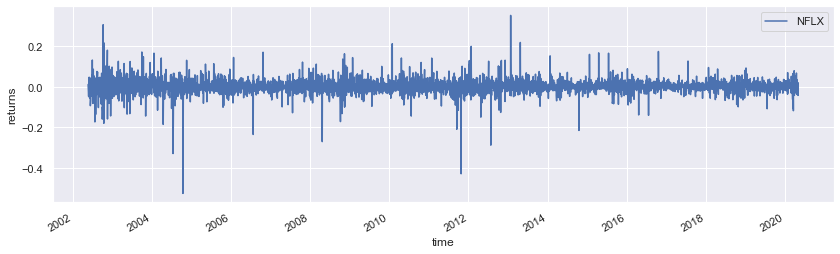

In [623]:
df = pd.DataFrame({'date':data.index[1:],'returns':returns})
df = df.set_index('date')

fig, ax = plt.subplots(figsize=(14,4))
df.plot(y='returns',label='NFLX',ax=ax)
ax.set(xlabel='time',ylabel='returns')

In [676]:
api = Tradier("0PZGXwG84qeJdfoeiDDgO3Ab3V2k")
NFLX200619P00350000 = api.options("NFLX").put(dt.date(2020, 6, 19), 350)

In [679]:
# leave out data with volume<100
end = NFLX200619P00350000.index.searchsorted(dt.datetime(2020,5,1))
nflxsubset = NFLX200619P00350000.iloc[:end].loc[NFLX200619P00350000['volume']>=100]
print(nflxsubset)

             open   high    low  close  volume
date                                          
2020-01-08  39.35  39.85  37.70  37.99     144
2020-01-31  32.45  32.50  31.20  31.50     131
2020-02-04  22.10  24.00  21.80  21.80     163
2020-02-06  21.25  22.60  21.25  22.40     231
2020-02-11  18.75  19.50  18.75  19.50     324
2020-02-12  18.20  18.20  16.74  16.74     223
2020-02-18  15.00  15.15  14.15  14.40     150
2020-02-19  14.35  14.90  13.45  14.77     451
2020-02-24  21.28  23.50  20.40  21.55     305
2020-02-27  21.46  22.40  17.85  22.10     191
2020-03-02  24.65  25.00  23.38  23.40     173
2020-03-05  23.85  29.00  20.20  27.90     111
2020-03-06  30.64  34.95  30.64  34.18     132
2020-03-11  37.05  43.00  36.10  40.65     252
2020-03-17  68.66  68.66  58.50  59.33     176
2020-03-23  36.00  41.50  33.30  33.92     186
2020-04-13  21.00  21.00  13.90  14.17     203
2020-04-14  14.50  14.50  10.25  10.27     176
2020-04-15  11.50  11.50   9.40  10.20     138
2020-04-16   

In [683]:
# For every trading day with volume>=100, calculate the MC estimate and compare with close price
data = yf.download('NFLX', start="2019-01-01",progressive=False)

k=350
gbm = []
loomerton = []
insmerton = []
lookou = []
inskou = []

# leave out data with volume<20
end = NFLX200619P00350000.index.searchsorted(dt.datetime(2020,5,1))
nflxsubset = NFLX200619P00350000.iloc[:end].loc[NFLX200619P00350000['volume']>=100]

for date in nflxsubset.index:
    #get daily risk free rate
    r = rate.loc[date]['Close']/100
    #get the end date
    date = dt.date(date.year,date.month,date.day)
    end = data.index.searchsorted(dt.datetime(date.year,date.month,date.day))

    nflx=np.array(data.iloc[:(end+1)]['Close'])
    returns = np.log(nflx[1:]/nflx[:(len(nflx)-1)])
    
    #jumps
    return_jumps = returns[abs(returns)>=0.11]


    if len(return_jumps)==0:
        return_jumps = np.array([0])
    
    t = len(pd.bdate_range(start=date,end='2020-6-19',freq='C',
               holidays=get_trading_close_holidays(2020),closed='right'))/252
    
    np.random.seed(2020)
    ## GBM Stratified
    vol = np.sqrt(np.var(returns)*252)
    kwargs1 = {'alpha':r, 'delta':0, 'sigma': vol, 't':t, 's':nflx[-1]}
    gbm.append(stratified_option_value_american(k,r,call=False,npath=1000,**kwargs1))   
    
    ## Merton
    sigma_j = (max(return_jumps) - min(return_jumps))/6
    alpha_j = np.mean(return_jumps)
    sigma = np.sqrt(max(0,np.var(returns)*252-lambda_*(sigma_j**2+alpha_j**2)))
    lambda_ = len(return_jumps)/len(returns)*252
    kwargs2 = {'alpha':r,'delta':0,'lambda_':lambda_, 'sigma':sigma, 'alpha_j': alpha_j, 
              'sigma_j':sigma_j,'t':t,'s':nflx[-1]}
    
    loomerton.append(lhs_option_value_american_merton(k,r,npath=1000,call=False,**kwargs2))
    insmerton.append(lhs_option_value_american_merton_lsm(k,r,npath=1000,call=False,**kwargs2))

    ## Kou
    p = sum(return_jumps>0)/max(len(return_jumps),1)
    q = 1-p
    # solve nonlinear system to get eta1, eta2 estimation
    def equations(u):
        x,y = u
        return (p/x-q/y-np.mean(return_jumps),(1-q**2)/x**2+(1-p**2)/y**2 + 2*
                p*q/(x*y)-np.var(return_jumps))
    
    eta1, eta2 = fsolve(equations, (5,10))
    #print([eta1,eta2])

    ### sigma correction
    sigma = np.sqrt(max(0,np.var(returns)*252-2*lambda_*(p/eta1**2+(1-p)/eta2**2)))
    
    kwargs3 = {'alpha':r, 'delta':0, 'lambda_':lambda_, 'sigma':sigma,
               'p':p, 'eta1':eta1, 'eta2':eta2, 't':t, 's':nflx[-1]}

    lookou.append(lhs_option_value_american_kou(k,r,npath=1000,call=False,**kwargs3))
    inskou.append(lhs_option_value_american_kou_lsm(k,r,npath=1000,call=False,**kwargs3))


[*********************100%***********************]  1 of 1 completed


C:\Users\kywan\.conda\envs\finance\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 600.
  warnings.warn(msg, RuntimeWarning)
C:\Users\kywan\.conda\envs\finance\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 600.
  warnings.warn(msg, RuntimeWarning)
C:\Users\kywan\.conda\envs\finance\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 600.
  warnings.warn(msg, RuntimeWarning)
C:\Users\kywan\.conda\envs\finance\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 600.
  warnings.warn(msg, RuntimeWarning)
C:\Users\kywan\.conda\envs\finance\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 600.
  warnings.warn(msg, RuntimeWarning)
C:\Users\kywan\.conda\env

In [686]:
#RMSE
print("RMSE for GBM: {}".format(
    np.sqrt(np.mean((gbm - nflxsubset['close'])**2))))
print("RMSE for LOO Merton: {}".format(
    np.sqrt(np.mean((loomerton - nflxsubset['close'])**2))))
print("RMSE for In sample Merton: {}".format(
    np.sqrt(np.mean((insmerton - nflxsubset['close'])**2))))
print("RMSE for LOO Kou: {}".format(
    np.sqrt(np.mean((lookou - nflxsubset['close'])**2))))
print("RMSE for In sample Kou: {}".format(
    np.sqrt(np.mean((inskou - nflxsubset['close'])**2))))


RMSE for GBM: 6.5277727633586915
RMSE for LOO Merton: 6.9521496511010294
RMSE for In sample Merton: 6.543624968040198
RMSE for LOO Kou: 6.909712396960491
RMSE for In sample Kou: 6.239272889841327


In [687]:
itm = 1*(data.loc[nflxsubset.index]['Close']<350)
result3 = {'Stock Close':data.loc[nflxsubset.index]['Close'],'ITM':itm,
           'Option Close':nflxsubset['close'],'GBM':gbm,'LOOMerton':loomerton,
           'InsampleMerton':insmerton,'LOOKou':lookou,'InsampleKou':inskou}

result3 = pd.DataFrame(result3)

result3

,Stock Close,ITM,Option Close,GBM,LOOMerton,InsampleMerton,LOOKou,InsampleKou
date,,,,,,,,
2020-01-08,339.260010,1,37.99,37.764910,36.807540,36.123211,34.611839,37.066969
2020-01-31,345.089996,1,31.50,32.186776,30.428651,33.321755,32.144712,33.502312
2020-02-04,369.010010,0,21.80,20.416584,20.261885,22.708261,20.993991,22.615119
2020-02-06,366.950012,0,22.40,21.896792,21.227247,22.564264,20.242777,23.418372
2020-02-11,373.690002,0,19.50,19.251929,17.777299,18.907988,19.009380,19.743933
2020-02-12,380.010010,0,16.74,16.304848,15.785807,16.830673,15.180000,16.151768
2020-02-18,387.779999,0,14.40,13.860558,13.466955,13.595063,13.770564,14.061597
2020-02-19,386.190002,0,14.77,14.571325,13.067986,15.254934,13.873046,14.406359
2020-02-24,368.700012,0,21.55,20.192322,18.915330,20.315852,19.466754,19.253437


In [706]:
# for 2020-03-02 -- 2020-04-27 use another approach
# For every trading day with volume>=100, calculate the MC estimate and compare with close price
data = yf.download('NFLX', start="2019-01-01",progressive=False)
nflx = np.array(data['Close'])
mu = np.mean(np.log(nflx[1:]/nflx[:(len(nflx)-1)]))
sd = np.std(np.log(nflx[1:]/nflx[:(len(nflx)-1)]))

k=350
gbm = []
loomerton = []
insmerton = []
lookou = []
inskou = []

# leave out data with volume<100
start = NFLX200619P00350000.index.searchsorted(dt.datetime(2020,3,1))
end = NFLX200619P00350000.index.searchsorted(dt.datetime(2020,5,1))
nflxsubset = NFLX200619P00350000.iloc[start:end].loc[NFLX200619P00350000['volume']>=100]

for date in nflxsubset.index:
    #get daily risk free rate
    r = rate.loc[date]['Close']/100
    #get the end date
    date = dt.date(date.year,date.month,date.day)
    end = data.index.searchsorted(dt.datetime(date.year,date.month,date.day))
    #use a 50 trading day rolling window to estimate parameters
    start = end-50

    nflx=np.array(data.iloc[start:(end+1)]['Close'])
    returns = np.log(nflx[1:]/nflx[:(len(nflx)-1)])
    
    #jumps
    return_jumps = returns[abs(returns-mu)>3*sd]


    if len(return_jumps)==0:
        
        return_jumps = np.array([0])
    
    t = len(pd.bdate_range(start=date,end='2020-6-19',freq='C',
               holidays=get_trading_close_holidays(2020),closed='right'))/252
    
    np.random.seed(2020)
    ## GBM Stratified
    vol = np.sqrt(np.var(returns)*252)
    kwargs1 = {'alpha':r, 'delta':0, 'sigma': vol, 't':t, 's':nflx[-1]}
    gbm.append(stratified_option_value_american(k,r,call=False,npath=1000,**kwargs1))   
    
    ## Merton
    sigma_j = (max(return_jumps) - min(return_jumps))/6
    alpha_j = np.mean(return_jumps)
    sigma = np.sqrt(max(0,np.var(returns)*252-lambda_*(sigma_j**2+alpha_j**2)))
    lambda_ = len(return_jumps)/len(returns)*252
    kwargs2 = {'alpha':r,'delta':0,'lambda_':lambda_, 'sigma':sigma, 'alpha_j': alpha_j, 
              'sigma_j':sigma_j,'t':t,'s':nflx[-1]}
    
    loomerton.append(lhs_option_value_american_merton(k,r,npath=1000,call=False,**kwargs2))
    insmerton.append(lhs_option_value_american_merton_lsm(k,r,npath=1000,call=False,**kwargs2))

    ## Kou
    p = sum(return_jumps>0)/max(len(return_jumps),1)
    q = 1-p
    # solve nonlinear system to get eta1, eta2 estimation
    def equations(u):
        x,y = u
        return (p/x-q/y-np.mean(return_jumps),(1-q**2)/x**2+(1-p**2)/y**2 + 2*
                p*q/(x*y)-np.var(return_jumps))
    
    eta1, eta2 = fsolve(equations, (5,10))
    #print([eta1,eta2])

    ### sigma correction
    sigma = np.sqrt(max(0,np.var(returns)*252-2*lambda_*(p/eta1**2+(1-p)/eta2**2)))
    
    kwargs3 = {'alpha':r, 'delta':0, 'lambda_':lambda_, 'sigma':sigma,
               'p':p, 'eta1':eta1, 'eta2':eta2, 't':t, 's':nflx[-1]}

    lookou.append(lhs_option_value_american_kou(k,r,npath=1000,call=False,**kwargs3))
    inskou.append(lhs_option_value_american_kou_lsm(k,r,npath=1000,call=False,**kwargs3))


[*********************100%***********************]  1 of 1 completed


C:\Users\kywan\.conda\envs\finance\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 600.
  warnings.warn(msg, RuntimeWarning)
C:\Users\kywan\.conda\envs\finance\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 600.
  warnings.warn(msg, RuntimeWarning)
C:\Users\kywan\.conda\envs\finance\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 600.
  warnings.warn(msg, RuntimeWarning)
C:\Users\kywan\.conda\envs\finance\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 600.
  warnings.warn(msg, RuntimeWarning)
C:\Users\kywan\.conda\envs\finance\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.wa

In [707]:
itm = 1*(data.loc[nflxsubset.index]['Close']<350)
result4 = {'Stock Close':data.loc[nflxsubset.index]['Close'],'ITM':itm,
           'Option Close':nflxsubset['close'],'GBM':gbm,'LOOMerton':loomerton,
           'InsampleMerton':insmerton,'LOOKou':lookou,'InsampleKou':inskou}

result4 = pd.DataFrame(result4)

result4

,Stock Close,ITM,Option Close,GBM,LOOMerton,InsampleMerton,LOOKou,InsampleKou
date,,,,,,,,
2020-03-02,381.049988,0,23.40,14.830003,13.740307,14.332448,12.568516,14.250439
2020-03-05,372.779999,0,27.90,17.955851,17.658533,18.223127,16.393284,18.443733
2020-03-06,368.970001,0,34.18,18.601290,18.339624,19.294198,18.403772,19.132699
2020-03-11,349.920013,1,40.65,29.624559,28.586021,30.257299,29.483305,30.851139
2020-03-17,319.750000,1,59.33,56.213674,56.245472,57.081241,51.127118,54.437312
2020-03-23,360.269989,0,33.92,37.826681,37.516058,38.869824,35.659377,34.938951
2020-04-13,396.720001,0,14.17,22.434396,22.945943,22.416224,21.713892,22.788326
2020-04-14,413.549988,0,10.27,18.686828,17.370958,17.483198,17.156125,17.108607
2020-04-15,426.750000,0,10.20,14.890085,14.642895,13.163116,14.661579,15.630538
